# Full-Atlantic Budget

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import glob
from zipfile import ZipFile
import gsw
import pandas as pd
import geopandas
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import time
import datetime
from scipy.stats import linregress
from scipy.stats import t
import scipy.stats as stats
import cmocean.cm as cmo
from erddapy import ERDDAP
import matplotlib.gridspec as gridspec
import cartopy
import geopy.distance
from scipy.interpolate import interp1d
import statsmodels.api as sm
from pyproj import Geod


In [2]:


def subset(ds,lon_min,lon_max,lat_min,lat_max):
    ## profiles that fulfill the lat/lon ranges
    ind = np.where((ds.LONGITUDE>=lon_min) & (ds.LONGITUDE<=lon_max) &
                   (ds.LATITUDE>=lat_min)  & (ds.LATITUDE<=lat_max))[0]
    ## subset
    subset_ds = xr.merge([ds.PSAL_CORRECTED[ind,:],
                      ds.POTM_CORRECTED[ind,:],
                      ds.DEPH_CORRECTED[ind,:],
                      ds.POSITION_QC[ind],
                      ds.PROFILE_POTM_QC[ind],
                      ds.PROFILE_PSAL_QC[ind],
                      ds.POTM_CORRECTED_QC[ind],
                      ds.PSAL_CORRECTED_QC[ind],
                      ds.INST_REFERENCE[ind],
                      ds.JULD[ind],
                      ds.LONGITUDE[ind],
                      ds.LATITUDE[ind],
                     ],combine_attrs='drop')
    return subset_ds




def qaqc(ds):
    ## Pull out profiles that fail check
    position_qc_ind = np.where(ds.POSITION_QC == b'4')[0]
    profile_potm_qc_ind = np.where(ds.PROFILE_POTM_QC == b'4')[0]
    profile_psal_qc_ind = np.where(ds.PROFILE_PSAL_QC == b'4')[0]
    potm_corrected_qc_ind = np.where(ds.POTM_CORRECTED_QC == b'4')[0]
    psal_corrected_qc_ind = np.where(ds.PSAL_CORRECTED_QC == b'4')[0]
    ## Combine indicies
    tot_qc_ind = np.unique(np.concatenate([position_qc_ind,profile_potm_qc_ind,profile_psal_qc_ind,potm_corrected_qc_ind,psal_corrected_qc_ind]))
    ## Remove from dataset
    ds.PSAL_CORRECTED[tot_qc_ind,:] = np.nan
    ds.POTM_CORRECTED[tot_qc_ind,:] = np.nan
    return ds




def gsw_convert(ds):
    
    lats = np.tile(ds.LATITUDE,(len(ds.N_LEVELS),1)).transpose()
    lons = np.tile(ds.LONGITUDE,(len(ds.N_LEVELS),1)).transpose()
    pressure = gsw.p_from_z(-ds.DEPH_CORRECTED, lats, geo_strf_dyn_height=0, sea_surface_geopotential=0)

    ds['absolute_salinity'] = gsw.SA_from_SP(ds.PSAL_CORRECTED, pressure, lons, lats)    
    ds['conservative_temperature'] = gsw.CT_from_pt(ds.absolute_salinity, ds.POTM_CORRECTED)
    
    return ds





def depth_grid(ds):
    ########################################################################################################################
    #### Depth grid interpolation
    depth_grid = np.concatenate([np.arange(0,101,5),np.arange(125,251,25),np.arange(300,1501,50),np.arange(1550,7000,250)])

    temp_interp = np.empty((len(depth_grid),ds.conservative_temperature.shape[1]))
    salt_interp = np.empty((len(depth_grid),ds.conservative_temperature.shape[1]))
    

    for x in np.arange(0,ds.conservative_temperature.shape[1]):
        temp_interp[:,x] = np.interp(depth_grid, ds.DEPH_CORRECTED.values[:,x], ds.conservative_temperature[:,x], left=np.nan, right=np.nan)
        salt_interp[:,x] = np.interp(depth_grid, ds.DEPH_CORRECTED.values[:,x], ds.absolute_salinity[:,x], left=np.nan, right=np.nan)
    ########################################################################################################################

    ## Check which profiles are NOT all nans
    non_nan_ind = np.where(np.sum(np.isnan(salt_interp),axis=0)!=len(depth_grid))[0]

    new_ds = xr.Dataset(
        data_vars=dict(
            conservative_temperature = (["depth", "time"], temp_interp[:,non_nan_ind]),
            absolute_salinity        = (["depth", "time"], salt_interp[:,non_nan_ind]),
            longitude                = (["time"], ds.LONGITUDE.values[non_nan_ind]),
            latitude                 = (["time"], ds.LATITUDE.values[non_nan_ind]),
            obs_type                 = (["time"], ds.INST_REFERENCE.values[non_nan_ind]))
            ,
        coords=dict(
            depth = depth_grid,
            time  = ds.JULD.values[non_nan_ind]))
    
    new_ds = new_ds.sortby('time')

    return new_ds








def spatial_grid(ds,lon_step,time=None):

    ########################################################################################################################
    #### Spatial grid
    # lon_step = 0.5 # degrees
    # lat_step = 0.5 # degrees

    ## Went larger than shapefile and then clip will trim
    lon_gridt = np.arange(-77.5,-17,lon_step)
    lat_max = 23    # started with 23
    lat_min = 20    # started with 20
    #lat_gridt = np.arange(21,24,lat_step)

    ## Lat/Lon grid mid points
    mid_lons = lon_gridt+(lon_step/2)
    #mid_lats = lat_gridt+(lat_step/2)

    ## For total anomaly
    if time == None:
        ## Preallocate
        grid_temp     = np.empty((len(ds.depth), len(lon_gridt),1))
        grid_temp[:]  = np.nan
        grid_salt     = np.empty((len(ds.depth), len(lon_gridt),1))
        grid_salt[:]  = np.nan
        grid_count    = np.empty(len(lon_gridt),1)
        grid_count[:] = np.nan
        
        ## Stuff data in the grid cells!
        for x in np.arange(0,len(lon_gridt)-1):
            #for y in np.arange(0,len(lat_gridt)-1):
            grid_ind = np.where((ds.longitude.values >= lon_gridt[x])   & 
                                    (ds.longitude.values <= lon_gridt[x+1]) &
                                    (ds.latitude.values  >= lat_min)   &
                                    (ds.latitude.values  <= lat_max))[0]

            grid_temp[:,x,0] = ds.conservative_temperature[:,grid_ind].mean(axis=1)
            grid_salt[:,x,0] = ds.absolute_salinity[:,grid_ind].mean(axis=1)
            grid_count[x,0]  = len(grid_ind)
    
        ### Make a new gridded dataset
        grid_ds = xr.Dataset(
            data_vars=dict(
                conservative_temperature=(["depth", "longitude","latitude"], grid_temp),
                absolute_salinity=(["depth", "longitude","latitude"], grid_salt),
                num_profs = (["latitude","longitude","latitude"],grid_count),
            ),
            coords=dict(
                longitude=mid_lons,
                latitude=np.atleast_1d(21.5),
                depth=ds.depth.values,
            ))
    ## Because adding time dimension
    else:
        # ## Preallocate
        # grid_temp     = np.empty((len(ds.depth), len(lat_gridt), len(lon_gridt),1))
        # grid_temp[:]  = np.nan
        # grid_salt     = np.empty((len(ds.depth), len(lat_gridt), len(lon_gridt),1))
        # grid_salt[:]  = np.nan
        # grid_count    = np.empty((len(lat_gridt), len(lon_gridt),1))
        # grid_count[:] = np.nan
        ## Preallocate
        grid_temp     = np.empty((len(ds.depth), len(lon_gridt),1,1))
        grid_temp[:]  = np.nan
        grid_salt     = np.empty((len(ds.depth), len(lon_gridt),1,1))
        grid_salt[:]  = np.nan
        grid_count    = np.empty((len(lon_gridt),1,1))
        grid_count[:] = np.nan
        
        ## Stuff data in the grid cells!
        for x in np.arange(0,len(lon_gridt)-1):
            grid_ind = np.where((ds.longitude.values >= lon_gridt[x])   & 
                                    (ds.longitude.values <= lon_gridt[x+1]) &
                                    (ds.latitude.values  >= lat_min)   &
                                    (ds.latitude.values  <= lat_max))[0]
                
            grid_temp[:,x,0,0] = ds.conservative_temperature[:,grid_ind].mean(axis=1)
            grid_salt[:,x,0,0] = ds.absolute_salinity[:,grid_ind].mean(axis=1)
            grid_count[x,0,0]  = len(grid_ind)
    
        
        
        ### Make a new gridded dataset
        grid_ds = xr.Dataset(
            data_vars=dict(
                conservative_temperature=(["depth", "longitude","latitude","time"], grid_temp),
                absolute_salinity=(["depth", "longitude","latitude","time"], grid_salt),
                num_profs = (["longitude","latitude","time"],grid_count),
            ),
            coords=dict(
                longitude=mid_lons,
                latitude=np.atleast_1d(21.5),
                depth=ds.depth.values,
                time=np.atleast_1d(pd.to_datetime(time)),
            ))

    return grid_ds




### These were pulled from: https://github.com/KirstieJane/STATISTICS/blob/master/CIs_LinearRegression.py

def lin_fit(x,y):
    '''
    Predicts the values for a best fit between numpy arrays x and y

    Parameters
    ----------
    x: 1D numpy array
    y: 1D numpy array (same length as x)

    Returns
    -------
    p:     parameters for linear fit of x to y
    y_err: 1D array of difference between y and fit values
               (same length as x)

    '''

    z = np.polyfit(x,y,1)
    p = np.poly1d(z)
    fit = p(x)

    y_err = y - fit

    return p, y_err

# ----------------------------------------------------------------------------

def conf_calc(x, y_err, c_limit=0.975, test_n=50):
    '''
    Calculates confidence interval of regression between x and y

    Parameters
    ----------
    x:       1D numpy array
    y_err:   1D numpy array of residuals (y - fit)
    c_limit: (optional) float number representing the area to the left
             of the critical value in the t-statistic table
             eg: for a 2 tailed 95% confidence interval (the default)
                    c_limit = 0.975
    test_n:  (optional) integer representing numer of equally-spaced
             x-points to predict in the range min(x) to max(x)

    Returns
    -------
    p_x:   1D array, length "test_n", with values spread evenly between
           min(x) and max(x)
    confs: 1D numpy array of predicted y values for x inputs

    '''
    # Define the variables you need
    # to calculate the confidence interval
    mean_x = np.mean(x)			# mean of x
    n = len(x)				# number of samples in origional fit
    tstat = t.ppf(c_limit, n-1)         # appropriate t value
    s_err = np.sum(np.power(y_err,2))	# sum of the squares of the residuals

    # create series of new test x-values to predict for
    p_x = np.linspace(np.min(x),np.max(x),test_n)

    confs = tstat * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/
			((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))

    return p_x, confs

# ----------------------------------------------------------------------------

def ylines_calc(p_x, confs, fit):
    '''
    Calculates the three lines that will be plotted

    Parameters
    ----------
    p_x:   1D array with values spread evenly between min(x) and max(x)
    confs: 1D array with confidence values for each value of p_x
    fit:   Predicted x -> y function (typically derived from np.poly1d)

    Returns
    -------
    p_y:    1D array with values corresponding to fit line (for p_x values)
    upper:  1D array, values corresponding to upper confidence limit line
    lower:  1D array, values corresponding to lower confidence limit line

    '''
    # now predict y based on test x-values
    p_y = fit(p_x)

    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - abs(confs)
    upper = p_y + abs(confs)

    return p_y, lower, upper

# ----------------------------------------------------------------------------

def plot_linreg_CIs(x, y, p_x, p_y, lower, upper):

    # set-up the plot
    #plt.xlabel('X values')
    #plt.ylabel('Y values')
    #plt.title('Linear regression and confidence limits')

    # plot sample data
    #plt.plot(x, y, 'bo', label='Sample observations')

    # plot line of best fit
    plt.plot(p_x, p_y, 'r-', color='black')

    # plot confidence limits
    plt.plot(p_x, lower, color='grey')
    plt.plot(p_x, upper, color='grey')

    # show the plot
    #plt.show()


def confidence_bounds(x, y, c_limit=0.975, test_n=50):
    '''
    Calculates the predicted (trend) line, and lower & upper confidene bounds
    from original x,y measurements

    Parameters
    ----------
    x: 1D numpy array
    y: 1D numpy array (same length as x)
    c_limit: (optional) float number representing the area to the left
             of the critical value in the t-statistic table
             eg: for a 2 tailed 95% confidence interval (the default)
                    c_limit = 0.975
    test_n:  (optional) integer representing numer of equally-spaced
             x-points to predict in the range min(x) to max(x)

    Returns
    -------
    p_x:    1D array with values spread evenly between min(x) and max(x)
            (length test_n)
    p_y:    1D array with values corresponding to fit line (for p_x values)
            (length test_n)
    upper:  1D array, values corresponding to upper confidence limit line
    lower:  1D array, values corresponding to lower confidence limit line

    '''

    # Fit x to y
    p, y_err = lin_fit(x ,y)

    # Calculate confidence intervals
    p_x, confs = conf_calc(x, y_err, c_limit=c_limit, test_n=test_n)

    # Calculate the lines for plotting:
    # The fit line, and lower and upper confidence bounds
    p_y, lower, upper = ylines_calc(p_x, confs, p)

    return p_x, p_y, lower, upper


    

## First figure out the clip-zone

/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


(-90.0, -15.0)

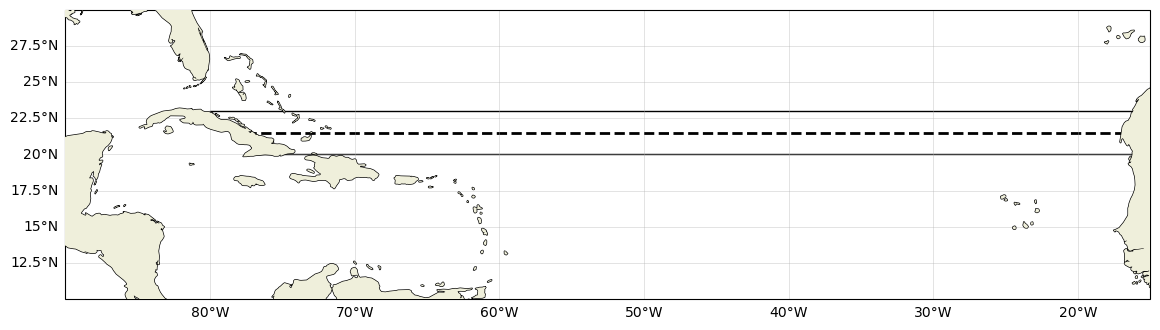

In [3]:

fig, ax = plt.subplots(figsize=(14,12),subplot_kw=dict(projection=cartopy.crs.PlateCarree()))

plt.plot([-80, -16], [23, 23],'k', linewidth=1,transform=cartopy.crs.PlateCarree())
plt.plot([-77.5, -16], [21.5, 21.5],'k--', linewidth=2,transform=cartopy.crs.PlateCarree())
plt.plot([-77.5, -16], [20, 20],'k', linewidth=1,transform=cartopy.crs.PlateCarree())


ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)
glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
ax.set_ylim(10,30)
ax.set_xlim(-90,-15)

# Pre-Processing Step 1:

**This does the following, looping through each file which represents all the data from a month in a year:**
1) Loads data
2) Subsets to box
3) QAQC
4) Depth grid interpolation
5) Save output

This takes ~8 minutes

In [4]:
# # Record the start time
# start_time = time.time()
# print("Start time:", datetime.datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S'))


# ## Extracted file name
# fnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/extracted/*.nc')

# for x in np.arange(0,len(fnames)):
#     ds = xr.open_dataset(fnames[x])

#     subset_ds = subset(ds,lon_min = -79,
#                       lon_max = -16,
#                       lat_min = 21,
#                       lat_max = 23)

#     subset_ds = qaqc(subset_ds)

#     ## Check if there is data after the QAQC
#     if len(subset_ds.N_PROF)==0:
#          continue
#     else:
#         ## Convert to absolute salinity and conservative temperature
#         subset_ds = gsw_convert(subset_ds)
#         ## Transpose to make dimensions make more sense
#         subset_ds = subset_ds.transpose()
#         ## Convert time here
#         subset_ds.JULD.values = pd.to_datetime(subset_ds.JULD)
#         ## Save
#         year = subset_ds.JULD.dt.year.values[0]
#         month = subset_ds.JULD.dt.month.values[0]
#         if len(str(month)) == 1:
#             month = '%02d' % month ## Make 2 digit month if it is only a 1 digit month (i.e. turn 3 into 03 for March)
    
#         ## Do the depth grid interpolation!!
#         subset_ds = depth_grid(subset_ds)   
    
#         ## Save
#         directory_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/Processed_ATL/'
#         save_file_name = ''.join([directory_name,"EN4_ATL_",str(year),str(month),".nc"])
#         subset_ds.to_netcdf(save_file_name)
    
    
# # Record the end time
# end_time = time.time()

# # Calculate the elapsed time
# elapsed_time = end_time - start_time

# # Print the elapsed time in seconds
# print(f"Elapsed time: {elapsed_time} seconds")



# Pre-Processing Step 2:

**This loads the individual months for each year and:**
1) Compute spatial mean
2) Save output

**This takes approximately 30 seconds**

In [5]:
# Record the start time
start_time = time.time()
print("Start time:", datetime.datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S'))


processed_fnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/Processed_ATL/*.nc')

for x in np.arange(0,len(processed_fnames)):
    ds1 = xr.open_dataset(processed_fnames[x])
    ds1['time'] = ds1.time.dt.strftime('%Y-%m')
    
    if len(ds1['time'].values) > 0:
        ## spatial mean
        year_ds = spatial_grid(ds1,lon_step=2,time=ds1['time'].values[0])   #### started with 2 deg
        ## Save
        year  = ds1['time'].values[0].split("-")[0]
        month = ds1['time'].values[0].split("-")[1]
        directory_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/Monthly_Means_ATL/'
        fname = processed_fnames[x].split("/")[-1].split('.')[0]
        save_file_name = ''.join([directory_name,fname,"_mean.nc"])
        year_ds.to_netcdf(save_file_name)


# Record the end time
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
# Print the elapsed time in seconds
print(f"Elapsed time: {elapsed_time} seconds")


Start time: 2024-08-02 09:16:29
Elapsed time: 14.269160032272339 seconds


# Load!

In [6]:
fnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/Monthly_Means_ATL/*.nc')

ds = xr.open_mfdataset(fnames,combine='nested', concat_dim='time')
## This is to dask plays nicely
ds = ds.load()
ds = ds.sortby('time')
## Add density
ds['potential_density'] = gsw.sigma0(ds.absolute_salinity, ds.conservative_temperature)+1000

# tot_ds = ds.mean(dim='time')
# ## Save
# save_file_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/EN4_ATL_Total_Spatial_Mean.nc'
# tot_ds.to_netcdf(save_file_name)

## Climatological spatial mean ds: PRELIMINARY
clim_mean_ds = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/EN4_ATL_Total_Spatial_Mean.nc')
clim_mean_ds['potential_density'] = gsw.sigma0(clim_mean_ds.absolute_salinity, clim_mean_ds.conservative_temperature)+1000
## convert CT and AS to PT and PSU
clim_mean_ds['potential_temp'] = gsw.pt_from_CT(clim_mean_ds.absolute_salinity, clim_mean_ds.conservative_temperature)
clim_mean_ds['practical_salinity'] = gsw.SP_from_SA(clim_mean_ds.absolute_salinity, gsw.p_from_z(-clim_mean_ds.depth,clim_mean_ds.latitude),clim_mean_ds.longitude,clim_mean_ds.latitude)

## Calculate standard deviation at each depth and longitude point
std_ds = ds.std(dim='time').isel(latitude=0)

###############################################################################################################################################
## IMPORT QAQC STEP HERE
###############################################################################################################################################

def filter_based_on_std(data,mean,std):
    ## Calculate the values difference from the mean
    diff_from_mean = np.abs(data - mean)
    ## If it is greater than 1 standard deviation from the mean, set it to nan
    if diff_from_mean > 2*std:
        data = np.nan
    return data


# Apply the function using xarray's apply_ufunc
new_temp = xr.apply_ufunc(
    filter_based_on_std,                     # function to apply
    ds.conservative_temperature,             # argument to pass to the function
    clim_mean_ds.conservative_temperature.mean(dim='longitude'),   # additional argument to pass to the function
    std_ds.conservative_temperature.mean(dim='longitude'),                        # additional argument to pass to the function
    #input_core_dims=[[''], '',''],   # core dimensions for input arrays
    #output_core_dims=[['new_depth']],            # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[ds.conservative_temperature.dtype]      # output dtype
)


# Apply the function using xarray's apply_ufunc
new_salt = xr.apply_ufunc(
    filter_based_on_std,                     # function to apply
    ds.absolute_salinity,             # argument to pass to the function
    clim_mean_ds.absolute_salinity.mean(dim='longitude'),   # additional argument to pass to the function
    std_ds.absolute_salinity.mean(dim='longitude'),                        # additional argument to pass to the function
    #input_core_dims=[[''], '',''],   # core dimensions for input arrays
    #output_core_dims=[['new_depth']],            # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[ds.absolute_salinity.dtype]      # output dtype
)

## Replace
ds['absolute_salinity'] = new_salt
ds['conservative_temperature'] = new_temp


ds

<xarray.Dataset>
Dimensions:                   (depth: 74, longitude: 31, latitude: 1, time: 570)
Coordinates:
  * longitude                 (longitude) float64 -76.5 -74.5 ... -18.5 -16.5
  * latitude                  (latitude) float64 21.5
  * depth                     (depth) int64 0 5 10 15 20 ... 6050 6300 6550 6800
  * time                      (time) datetime64[ns] 1911-06-01 ... 2023-11-01
Data variables:
    conservative_temperature  (depth, longitude, latitude, time) float64 nan ...
    absolute_salinity         (depth, longitude, latitude, time) float64 nan ...
    num_profs                 (longitude, latitude, time) float64 0.0 ... nan
    potential_density         (depth, longitude, latitude, time) float64 nan ...

/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


(-90.0, -15.0)

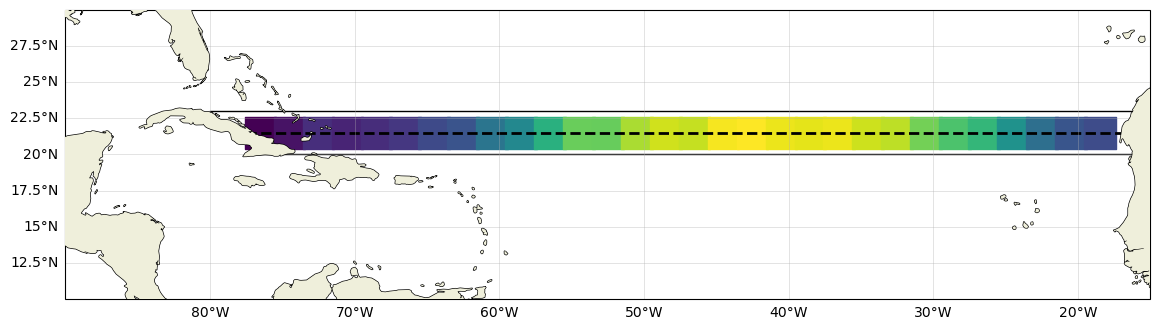

In [7]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(14,12),subplot_kw=dict(projection=cartopy.crs.PlateCarree()))

plt.plot([-80, -16], [23, 23],'k', linewidth=1,transform=cartopy.crs.PlateCarree())
plt.plot([-77.5, -16], [21.5, 21.5],'k--', linewidth=2,transform=cartopy.crs.PlateCarree())
plt.plot([-77.5, -16], [20, 20],'k', linewidth=1,transform=cartopy.crs.PlateCarree())

plt.scatter(ds.longitude,np.repeat(ds.latitude,len(ds.longitude)),c=ds.absolute_salinity.isel(depth=10).mean(dim='time').transpose(),s=520,marker='s',transform=cartopy.crs.PlateCarree())

#ax.add_patch(Rectangle(xy=(ds.longitude[0],ds.latitude,len(ds.longitude))),width=2, height=3,linewidth=1, color=ds.absolute_salinity.isel(depth=10).mean(dim='time').transpose()))

ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)
glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
ax.set_ylim(10,30)
ax.set_xlim(-90,-15)


/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


(-85.0, -60.0)

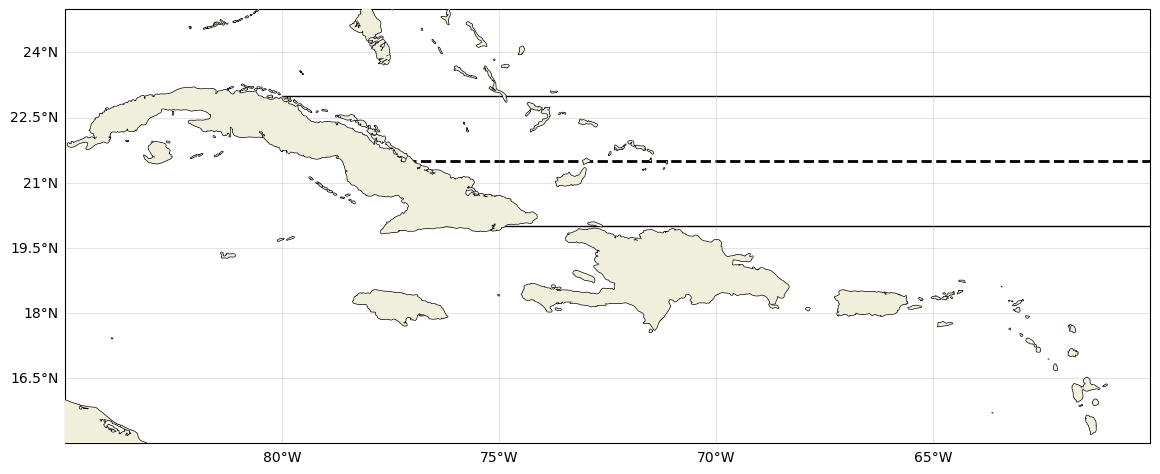

In [8]:

fig, ax = plt.subplots(figsize=(14,12),subplot_kw=dict(projection=cartopy.crs.PlateCarree()))

plt.plot([-80, -16], [23, 23],'k', linewidth=1,transform=cartopy.crs.PlateCarree())
plt.plot([-77.5, -16], [21.5, 21.5],'k--', linewidth=2,transform=cartopy.crs.PlateCarree())
plt.plot([-77.5, -16], [20, 20],'k', linewidth=1,transform=cartopy.crs.PlateCarree())

#plt.scatter(ds.longitude,np.repeat(ds.latitude,len(ds.longitude)),c=ds.absolute_salinity.isel(depth=10).mean(dim='time').transpose(),s=420,marker='s',transform=cartopy.crs.PlateCarree())

ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)
glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
ax.set_ylim(15,25)
ax.set_xlim(-85,-60)
#ax.set_xlim(-30,-10)


(5500.0, 0.0)

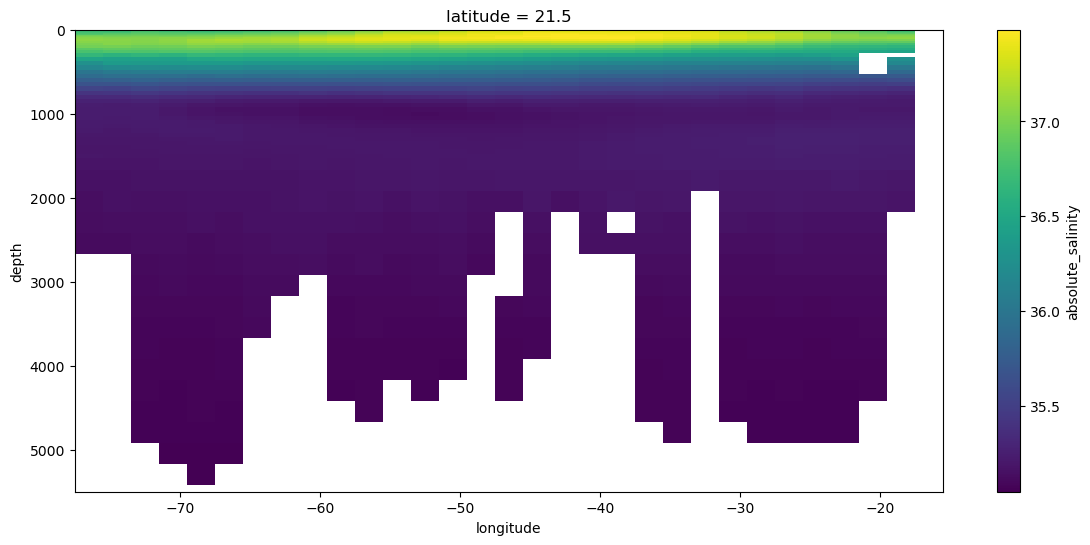

In [9]:
plt.figure(figsize=(14,6))
ds.absolute_salinity.mean(dim='time').isel(latitude=0).plot()
plt.ylim(5500,0)

## Decadal means

In [10]:
## Remove all-time means first to calculate anomalies
ds['salinity_anomaly'] = ds.absolute_salinity -clim_mean_ds.absolute_salinity
ds['temperature_anomaly'] = ds.conservative_temperature -clim_mean_ds.conservative_temperature
ds['density_anomaly'] = ds.potential_density -clim_mean_ds.potential_density

## Decadal mean since 1960
decadal_ds = ds.copy()
decadal_ds['time'] = (decadal_ds.time.dt.year//10)*10
decadal_ds = decadal_ds.where(decadal_ds.time>=1960,drop=True)
decadal_ds = decadal_ds.groupby(decadal_ds.time).mean()

## Add all-time means back in and replace original variables
decadal_ds['absolute_salinity'] = decadal_ds.salinity_anomaly +clim_mean_ds.absolute_salinity
decadal_ds['conservative_temperature'] = decadal_ds.temperature_anomaly +clim_mean_ds.conservative_temperature
decadal_ds['potential_density'] = decadal_ds.density_anomaly +clim_mean_ds.potential_density

## Delete anomaly variables
decadal_ds = decadal_ds.drop(['salinity_anomaly','temperature_anomaly','density_anomaly'])

## convert CT and AS to PT and PSU
decadal_ds['potential_temp'] = gsw.pt_from_CT(decadal_ds.absolute_salinity, decadal_ds.conservative_temperature)
decadal_ds['practical_salinity'] = gsw.SP_from_SA(decadal_ds.absolute_salinity, gsw.p_from_z(-decadal_ds.depth,decadal_ds.latitude),decadal_ds.longitude,decadal_ds.latitude)

decadal_ds

<xarray.Dataset>
Dimensions:                   (time: 7, depth: 74, longitude: 31, latitude: 1)
Coordinates:
  * longitude                 (longitude) float64 -76.5 -74.5 ... -18.5 -16.5
  * latitude                  (latitude) float64 21.5
  * depth                     (depth) int64 0 5 10 15 20 ... 6050 6300 6550 6800
  * time                      (time) int64 1960 1970 1980 1990 2000 2010 2020
Data variables:
    conservative_temperature  (time, depth, longitude, latitude) float64 26.5...
    absolute_salinity         (time, depth, longitude, latitude) float64 36.8...
    num_profs                 (time, longitude, latitude) float64 0.1 ... nan
    potential_density         (time, depth, longitude, latitude) float64 1.02...
    potential_temp            (time, depth, longitude, latitude) float64 26.5...
    practical_salinity        (time, depth, longitude, latitude) float64 36.6...

## MASK:

Mask based on the all-time mean fields to grab where there is NON-nan data. This way, can look at the decadal means and fill where those are nan with the all-time means.

### Before:

(5000.0, 0.0)

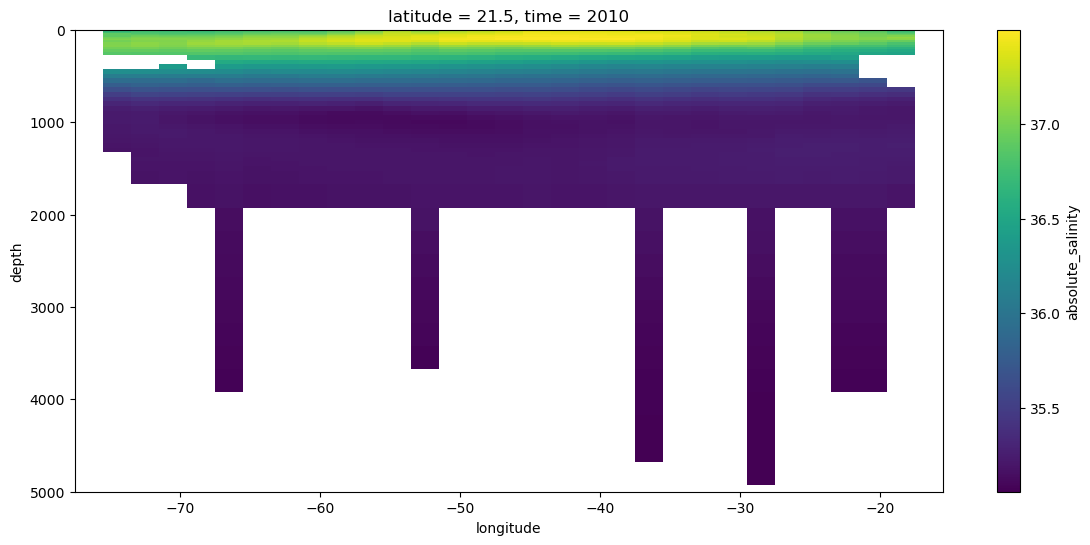

In [11]:
plt.figure(figsize=(14,6))
decadal_ds.absolute_salinity.isel(latitude=0,time=5).plot()
plt.ylim(5000,0)

In [12]:
decadal_ds = decadal_ds.combine_first(clim_mean_ds)
decadal_ds

<xarray.Dataset>
Dimensions:                   (time: 7, depth: 74, longitude: 31, latitude: 1)
Coordinates:
  * longitude                 (longitude) float64 -76.5 -74.5 ... -18.5 -16.5
  * latitude                  (latitude) float64 21.5
  * depth                     (depth) int64 0 5 10 15 20 ... 6050 6300 6550 6800
  * time                      (time) int64 1960 1970 1980 1990 2000 2010 2020
Data variables:
    conservative_temperature  (time, depth, longitude, latitude) float64 26.5...
    absolute_salinity         (time, depth, longitude, latitude) float64 36.8...
    num_profs                 (time, longitude, latitude) float64 0.1 ... nan
    potential_density         (time, depth, longitude, latitude) float64 1.02...
    potential_temp            (time, depth, longitude, latitude) float64 26.5...
    practical_salinity        (time, depth, longitude, latitude) float64 36.6...
    potential_temperature     (depth, longitude, latitude) float64 26.1 ... nan

## After

(5000.0, 0.0)

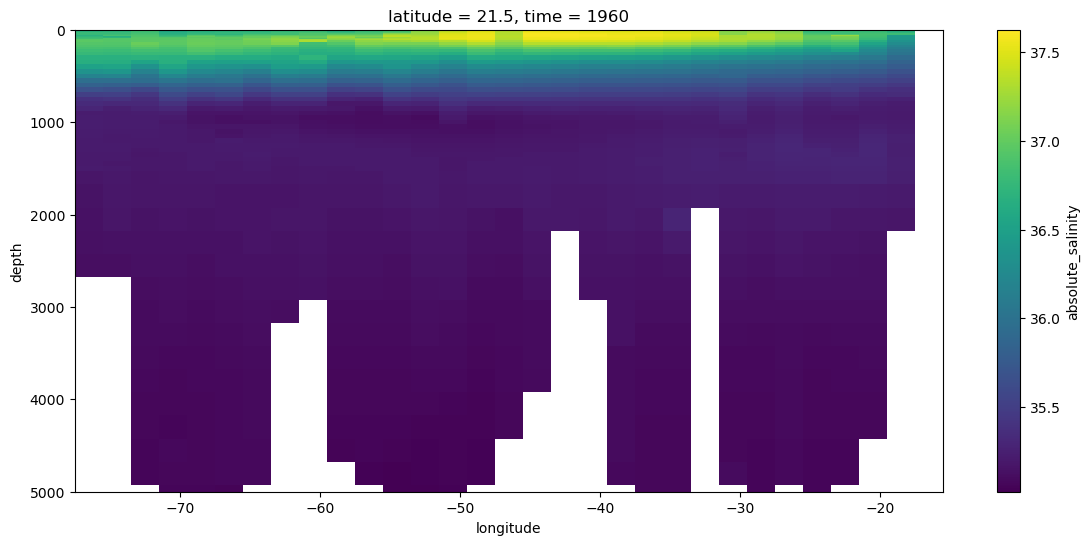

In [13]:
plt.figure(figsize=(14,6))
decadal_ds.absolute_salinity.isel(time=0,latitude=0).plot()
plt.ylim(5000,0)

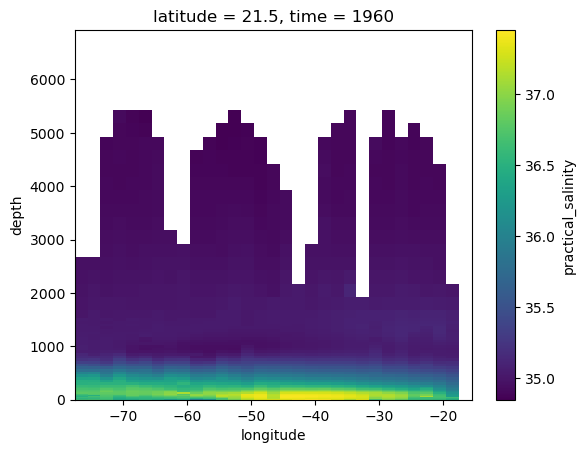

In [14]:
decadal_ds.practical_salinity.isel(time=0,latitude=0).plot()

## Calculate trends at depth levels for each longitude

In [15]:
def trends_on_depth_levels(data,tm):
    nanind = np.isfinite(data) ## these are NON-na
    new_data = data[nanind]
    tmm = tm[nanind]
    
    if len(new_data)>0:
        slope, _, _, _, _  = linregress(tmm,new_data)
    else:
        slope = np.nan
    return(slope)


#######################################################################
#### REFORMATING TIME
repeated_array = xr.DataArray(decadal_ds.time.values, dims="time") \
                  .broadcast_like(decadal_ds) \
                  .transpose("time", "depth", "longitude","latitude")
#######################################################################

decadal_ds = decadal_ds.chunk({'time': -1})



# Apply the function using xarray's apply_ufunc
slope_temp = xr.apply_ufunc(
    trends_on_depth_levels,            # function to apply
    decadal_ds.conservative_temperature.isel(latitude=0),              # argument to pass to the function
    repeated_array.isel(latitude=0),                           # additional argument to pass to the function
    input_core_dims=[['time'],['time']],    # core dimensions for input arrays
    #output_core_dims=[['depth','longitude']],       # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[ds.conservative_temperature.dtype]
)



# Apply the function using xarray's apply_ufunc
slope_salt = xr.apply_ufunc(
    trends_on_depth_levels,            # function to apply
    decadal_ds.absolute_salinity.isel(latitude=0),              # argument to pass to the function
    repeated_array.isel(latitude=0),                           # additional argument to pass to the function
    input_core_dims=[['time'],['time']],    # core dimensions for input arrays
    #output_core_dims=[['depth','longitude']],       # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[ds.absolute_salinity.dtype]
)




## Convert to per decade
slope_temp = slope_temp*10
slope_salt = slope_salt*10



(5500.0, 0.0)

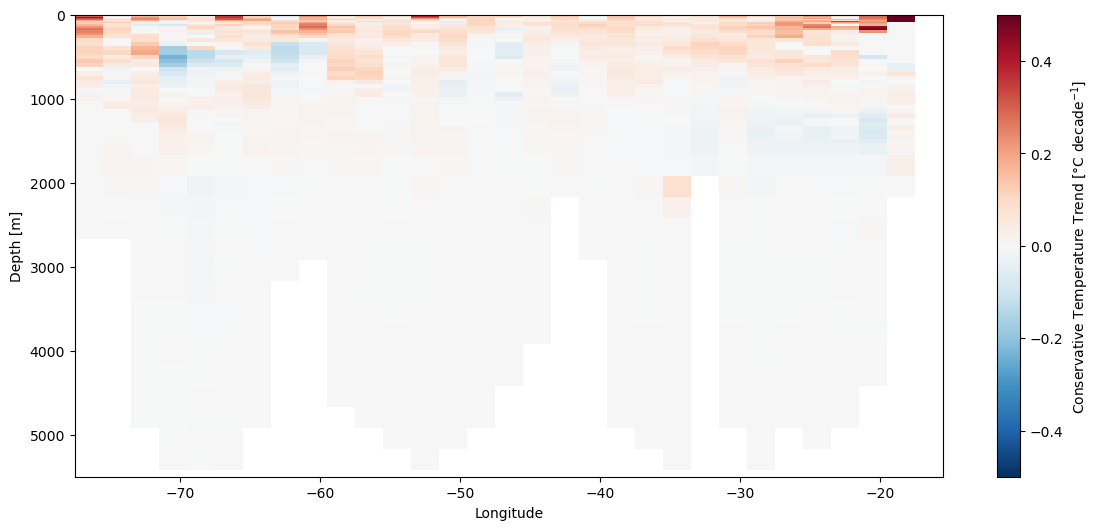

In [16]:
plt.figure(figsize=(14,6))
plt.pcolormesh(decadal_ds.longitude.values,decadal_ds.depth.values,slope_temp,cmap='RdBu_r',vmin=-0.5,vmax=0.5)
plt.colorbar(label='Conservative Temperature Trend [°C decade$^{-1}$]')
plt.ylabel('Depth [m]')
plt.xlabel('Longitude')
plt.ylim(5500,0)

(5500.0, 0.0)

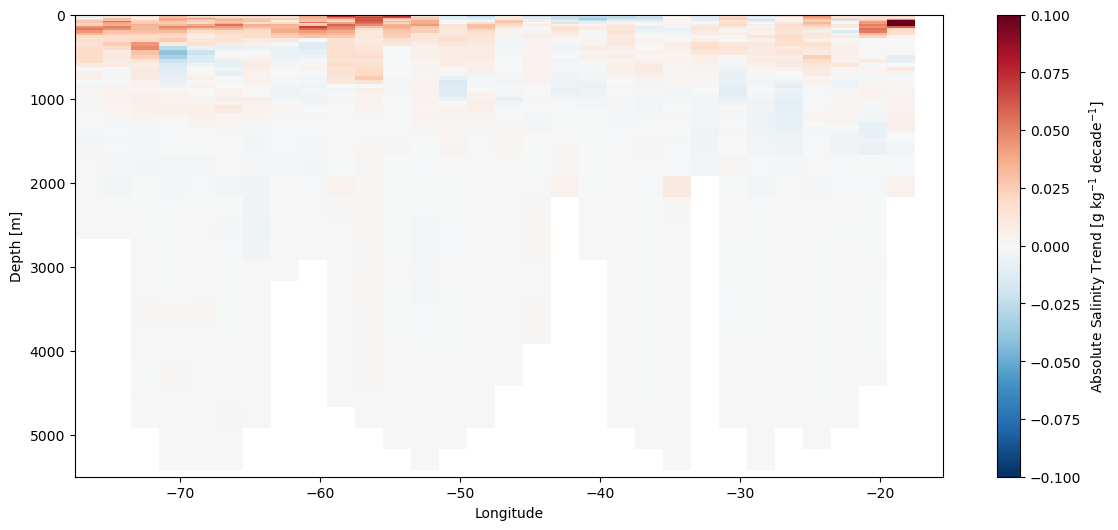

In [17]:
plt.figure(figsize=(14,6))
plt.pcolormesh(decadal_ds.longitude.values,decadal_ds.depth.values,slope_salt,cmap='RdBu_r',vmin=-0.1,vmax=0.1)
plt.colorbar(label='Absolute Salinity Trend [g kg$^{-1}$ decade$^{-1}$]')
plt.ylabel('Depth [m]')
plt.xlabel('Longitude')
plt.ylim(5500,0)
#plt.xlim(-30,-15)

/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_82305/736784652.py:1: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(slope_temp,axis=1),decadal_ds.depth)


Text(0, 0.5, 'Depth [m]')

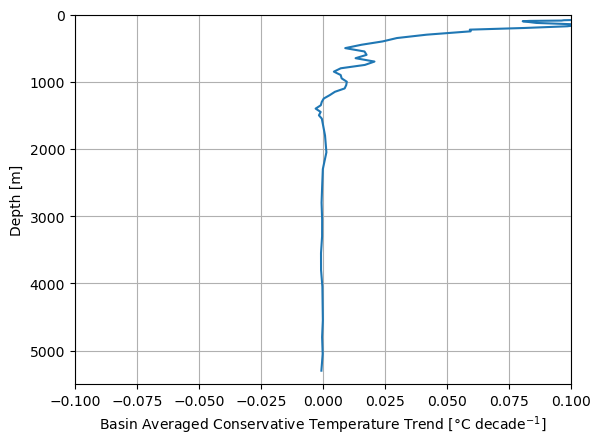

In [18]:
plt.plot(np.nanmean(slope_temp,axis=1),decadal_ds.depth)
plt.grid()
plt.ylim(5500,0)
plt.xlim(-0.1,0.1)
plt.xlabel('Basin Averaged Conservative Temperature Trend [°C decade$^{-1}$]')
plt.ylabel('Depth [m]')

/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_82305/431981698.py:2: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(slope_salt,axis=1),decadal_ds.depth)


Text(0, 0.5, 'Depth [m]')

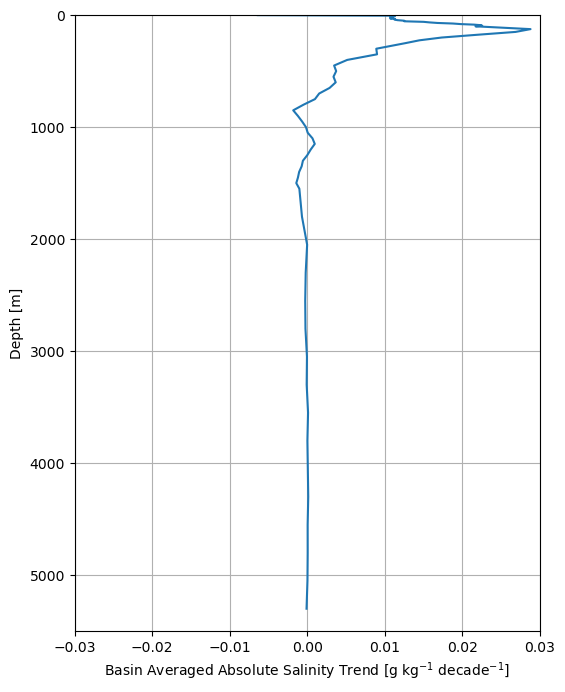

In [19]:
plt.figure(figsize=(6,8))
plt.plot(np.nanmean(slope_salt,axis=1),decadal_ds.depth)
plt.grid()
plt.ylim(5500,0)
plt.xlim(-0.03,0.03)
plt.xlabel('Basin Averaged Absolute Salinity Trend [g kg$^{-1}$ decade$^{-1}$]')
plt.ylabel('Depth [m]')

# Now GLORYS Velocity Fields

In [20]:
fnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/*.nc')
glorys = xr.open_mfdataset(fnames,data_vars='minimal',coords='minimal',compat='override',chunks='auto')

## Convert to TEOS-10
pressure = gsw.p_from_z(-glorys.depth,glorys.latitude)
glorys['absolute_salinity'] = gsw.SA_from_SP(glorys.so, pressure, glorys.longitude, glorys.latitude)    
glorys['conservative_temperature'] = gsw.CT_from_pt(glorys.so, glorys.thetao)
glorys['potential_density'] = gsw.sigma0(glorys.absolute_salinity, glorys.conservative_temperature)+1000
## Update attributes
glorys.absolute_salinity.attrs['long_name'] = 'Absolute Salinity'
glorys.absolute_salinity.attrs['unit_long'] = 'Absolute Salinity'
glorys.absolute_salinity.attrs['units'] = 'g kg$^{-1}$'
glorys.conservative_temperature.attrs['long_name'] = 'Conservative Temperature'
glorys.conservative_temperature.attrs['unit_long'] = 'Conservative Temperature'
glorys.conservative_temperature.attrs['units'] = '°C'
glorys.potential_density.attrs['long_name'] = 'Potential Density'
glorys.potential_density.attrs['unit_long'] = 'Potential Density'
glorys.potential_density.attrs['units'] = 'kg m$^{-3}$'

glorys

<xarray.Dataset>
Dimensions:                   (depth: 50, latitude: 265, longitude: 1009,
                               time: 373)
Coordinates:
  * depth                     (depth) float32 0.494 1.541 ... 5.728e+03
  * latitude                  (latitude) float32 8.0 8.083 8.167 ... 29.92 30.0
  * longitude                 (longitude) float32 -98.0 -97.92 ... -14.08 -14.0
  * time                      (time) datetime64[ns] 1993-01-01 ... 2023-12-01
Data variables:
    so                        (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    thetao                    (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    uo                        (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    vo                        (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    absolute_salinity         (time, depth, latitude, longitude) float64 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    conservative_temperature  (time, depth, latitude, longitude) float64 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    potential_density         (time, depth, latitude, longitude) float64 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
Attributes: (12/14)
    Conventions:                   CF-1.6
    area:                          GLOBAL
    contact:                       servicedesk.cmems@mercator-ocean.eu
    credit:                        E.U. Copernicus Marine Service Information...
    dataset:                       global-reanalysis-001-030-monthly
    institution:                   Mercator Ocean
    ...                            ...
    product:                       GLOBAL_REANALYSIS_001_030
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    references:                    http://marine.copernicus.eu
    source:                        MERCATOR GLORYS12V1
    title:                         Monthly mean fields for product GLOBAL_REA...

## Create greater Atlantic slice

In [21]:
glorys_atl = glorys.where((glorys.latitude==21.5) & (glorys.longitude>=-77.5),drop=True).mean(dim='time')
glorys_atl

<xarray.Dataset>
Dimensions:                   (depth: 50, latitude: 1, longitude: 763)
Coordinates:
  * depth                     (depth) float32 0.494 1.541 ... 5.728e+03
  * latitude                  (latitude) float32 21.5
  * longitude                 (longitude) float32 -77.5 -77.42 ... -14.08 -14.0
Data variables:
    so                        (depth, latitude, longitude) float32 dask.array<chunksize=(33, 1, 453), meta=np.ndarray>
    thetao                    (depth, latitude, longitude) float32 dask.array<chunksize=(33, 1, 453), meta=np.ndarray>
    uo                        (depth, latitude, longitude) float32 dask.array<chunksize=(33, 1, 453), meta=np.ndarray>
    vo                        (depth, latitude, longitude) float32 dask.array<chunksize=(33, 1, 453), meta=np.ndarray>
    absolute_salinity         (depth, latitude, longitude) float64 dask.array<chunksize=(33, 1, 453), meta=np.ndarray>
    conservative_temperature  (depth, latitude, longitude) float64 dask.array<chunksize=(33, 1, 453), meta=np.ndarray>
    potential_density         (depth, latitude, longitude) float64 dask.array<chunksize=(33, 1, 453), meta=np.ndarray>

(5500.0, 0.0)

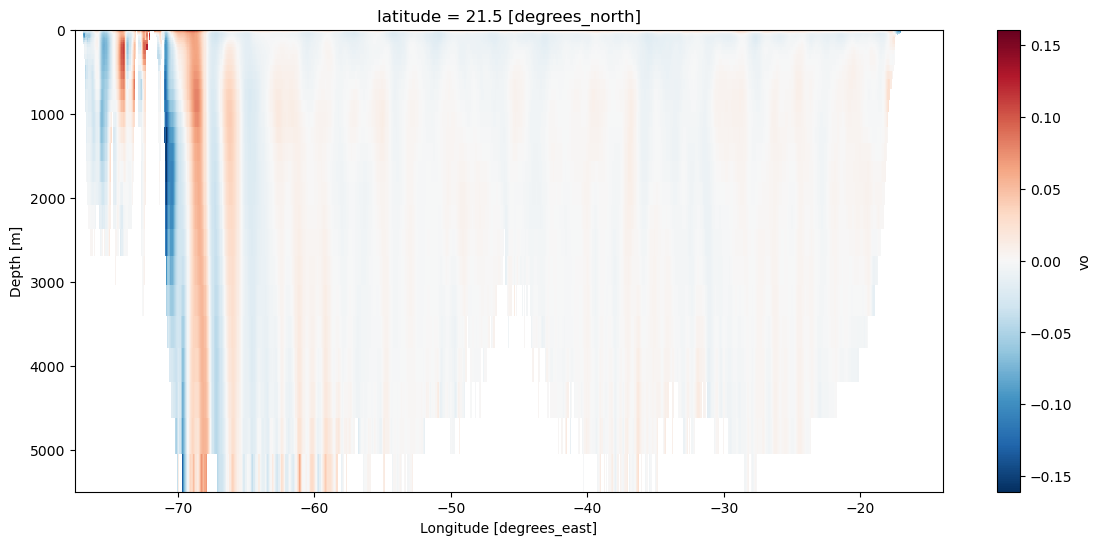

In [22]:
plt.figure(figsize=(14,6))
glorys_atl.vo.isel(latitude=0).plot()
plt.ylim(5500,0)
#plt.xlim(-80,-65)
#plt.xlim(-30,-10)

## Interpolate onto EN4 longitude grid

In [23]:
dz = 1
grid_depth = np.arange(0.5, glorys_atl.depth.max().values, dz)

def depth_interp(old_depth,vel,new_depth):
    # new_vel = np.empty((len(new_depth),len(glorys_atl.longitude)))
    # new_vel[:] = np.nan

    interp_func = interp1d(old_depth, vel, kind='linear')
    return interp_func(new_depth)

    # for x in np.arange(0,len(glorys_atl.longitude)):
    #     interp_func = interp1d(old_depth, vel[:,x], kind='linear')
    #     new_vel[:,x] = interp_func(new_depth)
    # return new_vel

glorys_atl = glorys_atl.chunk({'depth': -1})
glorys_atl = glorys_atl.chunk({'longitude': -1})

# Apply the function using xarray's apply_ufunc
new_vel = xr.apply_ufunc(
    depth_interp,                            # function to apply
    glorys_atl.depth,                           # additional argument to pass to the function
    glorys_atl.vo.isel(latitude=0),                        # additional argument to pass to the function
    grid_depth,                              # input array
    input_core_dims=[['depth'], ['depth'],['new_depth']],  # core dimensions for input arrays
    output_core_dims=[['new_depth']],            # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[glorys_atl.vo.dtype]      # output dtype
)


## Make new xr with this array for saving

In [24]:
# Create the xarray dataset
glorys_atl_vo_interp_ds = xr.Dataset(
    {
        "vvel": (["depth", "longitude"], new_vel.transpose().values)
    },
    coords={
        "longitude": glorys_atl.longitude.values,
        "depth": grid_depth.flatten(),
        "latitude":np.atleast_1d(21.0),
    },
)

glorys_atl_vo_interp_ds


<xarray.Dataset>
Dimensions:    (depth: 5728, longitude: 763, latitude: 1)
Coordinates:
  * longitude  (longitude) float32 -77.5 -77.42 -77.33 ... -14.17 -14.08 -14.0
  * depth      (depth) float64 0.5 1.5 2.5 3.5 ... 5.726e+03 5.726e+03 5.728e+03
  * latitude   (latitude) float64 21.0
Data variables:
    vvel       (depth, longitude) float32 nan nan nan nan ... nan nan nan nan

In [25]:
# glorys_atl_vo_interp_ds.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_21_5N_1m_dz_vvel_interp.nc')

## Reload

In [26]:
#glorys_atl_vo_interp_ds = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_22N_1m_dz_vvel_interp.nc')
#glorys_atl_vo_interp_ds = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_21N_1m_dz_vvel_interp.nc')
glorys_atl_vo_interp_ds = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_21_5N_1m_dz_vvel_interp.nc')
glorys_atl_vo_interp_ds

<xarray.Dataset>
Dimensions:    (depth: 5728, longitude: 763, latitude: 1)
Coordinates:
  * longitude  (longitude) float32 -77.5 -77.42 -77.33 ... -14.17 -14.08 -14.0
  * depth      (depth) float64 0.5 1.5 2.5 3.5 ... 5.726e+03 5.726e+03 5.728e+03
  * latitude   (latitude) float64 21.0
Data variables:
    vvel       (depth, longitude) float32 ...

(5500.0, 0.0)

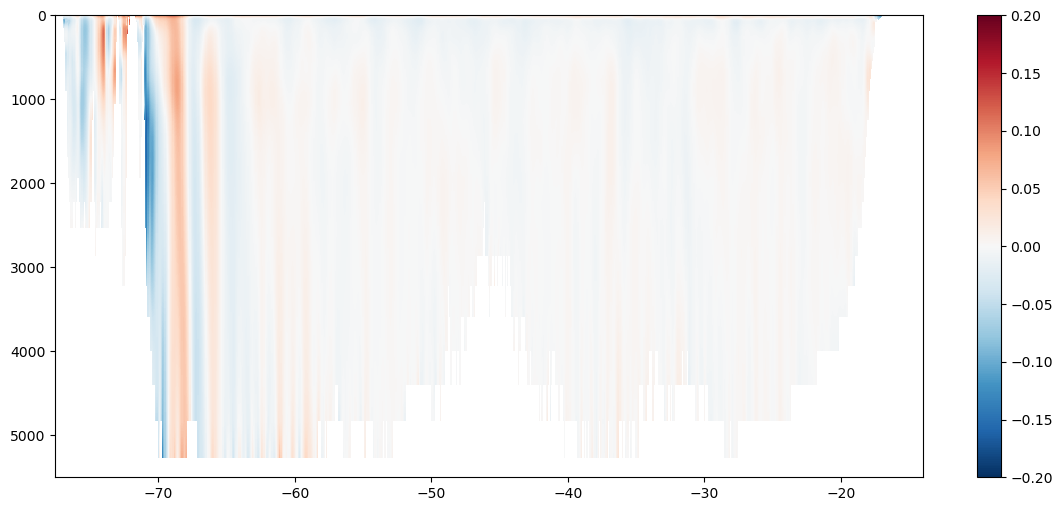

In [27]:
plt.figure(figsize=(14,6))
plt.pcolormesh(glorys_atl_vo_interp_ds.longitude,glorys_atl_vo_interp_ds.depth,glorys_atl_vo_interp_ds.vvel,cmap='RdBu_r',vmin=-0.2,vmax=0.2)
plt.colorbar()
plt.ylim(5500,0)
#plt.xlim(-80,-70)

In [28]:

## Coarse
#dx = geopy.distance.geodesic([ds.longitude.values[0],ds.latitude.values[0]], [ds.longitude.values[1],ds.latitude.values[0]]).m

## Fine
dx = geopy.distance.geodesic([glorys_atl.longitude.values[0],glorys_atl.latitude.values[0]], [glorys_atl.longitude.values[1],glorys_atl.latitude.values[0]]).m
dx

9303.680337611735

In [29]:
atl_transport_per_unit_depth = (glorys_atl_vo_interp_ds.vvel*dx)
atl_transport_per_unit_depth

<xarray.DataArray 'vvel' (depth: 5728, longitude: 763)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -77.5 -77.42 -77.33 ... -14.17 -14.08 -14.0
  * depth      (depth) float64 0.5 1.5 2.5 3.5 ... 5.726e+03 5.726e+03 5.728e+03

Text(0.5, 1.0, 'Greater Atlantic along 21.5°N')

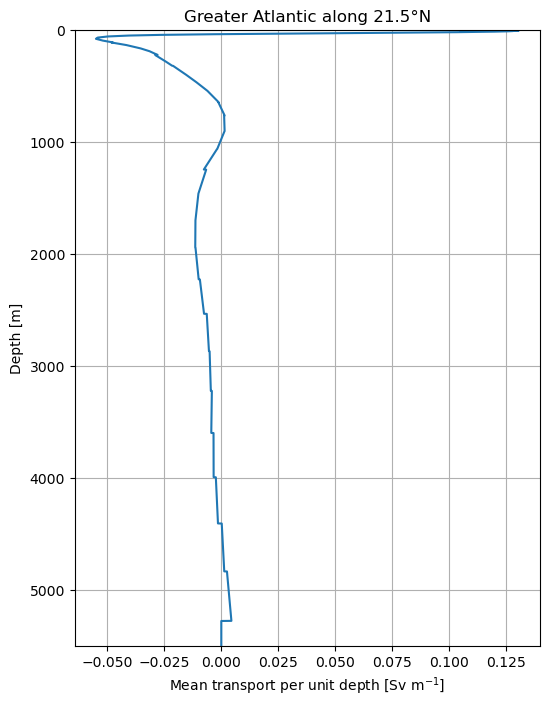

In [30]:
plt.figure(figsize=(6,8))
plt.plot(atl_transport_per_unit_depth.sum(dim='longitude')/(10**6),atl_transport_per_unit_depth.depth)
plt.ylim(5500,0)
plt.grid()
#plt.xlim(-0.13,0.13)
plt.ylabel('Depth [m]')
plt.xlabel('Mean transport per unit depth [Sv m$^{-1}$]')
plt.title('Greater Atlantic along 21.5°N')

In [31]:
np.nansum(atl_transport_per_unit_depth)/(10**6)

-29.196854

In [ ]:
np.nansum(atl_transport_per_unit_depth)/(10**6)

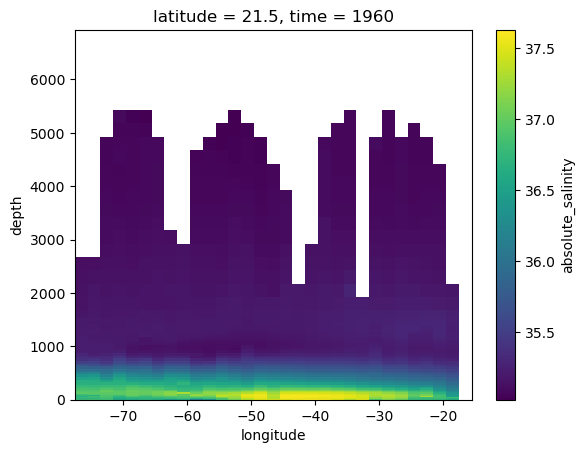

In [36]:
decadal_ds.absolute_salinity.isel(time=0,latitude=0).plot()

## Put trend profiles on 1 m dz grid

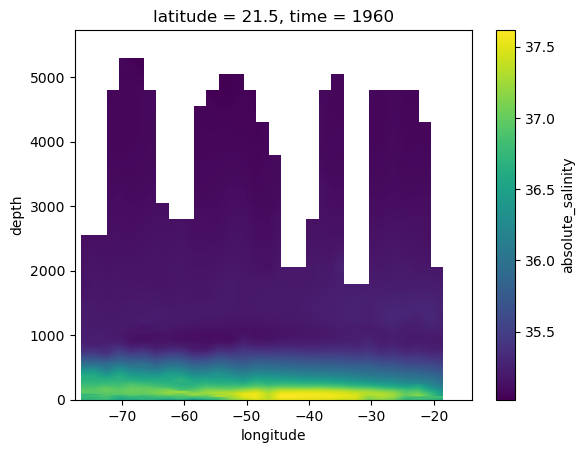

In [37]:
decadal_ds_interp = decadal_ds.interp_like(atl_transport_per_unit_depth)
decadal_ds_interp.absolute_salinity.isel(time=0,latitude=0).plot()

In [287]:
decadal_ds_interp.isel(latitude=0)

<xarray.Dataset>
Dimensions:                   (time: 7, depth: 5728, longitude: 763)
Coordinates:
    latitude                  float64 21.5
  * time                      (time) int64 1960 1970 1980 1990 2000 2010 2020
  * depth                     (depth) float64 0.5 1.5 ... 5.726e+03 5.728e+03
  * longitude                 (longitude) float32 -77.5 -77.42 ... -14.08 -14.0
Data variables:
    conservative_temperature  (time, depth, longitude) float64 dask.array<chunksize=(7, 5728, 763), meta=np.ndarray>
    absolute_salinity         (time, depth, longitude) float64 dask.array<chunksize=(7, 5728, 763), meta=np.ndarray>
    num_profs                 (time, longitude) float64 dask.array<chunksize=(7, 763), meta=np.ndarray>
    potential_density         (time, depth, longitude) float64 dask.array<chunksize=(7, 5728, 763), meta=np.ndarray>
    potential_temp            (time, depth, longitude) float64 dask.array<chunksize=(7, 5728, 763), meta=np.ndarray>
    practical_salinity        (time, depth, longitude) float64 dask.array<chunksize=(7, 5728, 763), meta=np.ndarray>

## Yucatan Straits Transport

In [38]:
geodesic = Geod(ellps="WGS84")  # define the coordinate system. WGS84 is the standard used by GPS.

def calculate_transect(start, end, dist=5000):
    from pyproj import Geod
    g = Geod(ellps="WGS84")
    
    pts = g.inv_intermediate(start[0], start[1], end[0], end[1], 0, dist) 
    _, _, dist = g.inv(np.full(len(pts.lons), start[0]), np.full(len(pts.lons), start[1]), pts.lons, pts.lats)
    return np.column_stack([pts.lons, pts.lats]), dist


def reckon(origin_lon, origin_lat, forward_azimuth, distance):
    """
    Calculate lon, lat of a point from a specified azimuth, distance on sphere or ellipsoid
    Helper function for pyproj.Geod forward transformation

    Args:
        origin_lon (array, numpy.ndarray, list, tuple, or scalar):
            Longitude(s) of initial point(s)
        origin_lat (array, numpy.ndarray, list, tuple, or scalar):
            Latitude(s) of initial point(s)
        forward_azimuth (array, numpy.ndarray, list, tuple, or scalar):
            Azimuth/bearing(s) of the terminus point relative to the initial point(s)
        distance (array, numpy.ndarray, list, tuple, or scalar):
            Distance(s) between initial and terminus point(s) in kilometers

    Returns:
        array, numpy.ndarray, list, tuple, or scalar: Longitude(s) of terminus point(s)
        array, numpy.ndarray, list, tuple, or scalar: Latitude(s) of terminus point(s)
        array, numpy.ndarray, list, tuple, or scalar: Backwards azimuth(s) of terminus point(s)
    """
    terminus_lon, terminus_lat, _ = geodesic.fwd(origin_lon, origin_lat, forward_azimuth, distance * 1000)
    return terminus_lon, terminus_lat



yucatan_pt1 = [-86.742, 21.1256]
yucatan_pt2 = [-84.9348, 21.837]

# yucatan_pt1 = [-86.742, 21.1256]
# yucatan_pt2 = [-86.742-(1/12), 21.1256+(1/12)]
# geopy.distance.geodesic(yucatan_pt2, yucatan_pt1).m #### ~9km

yucatan_dx = 9000

pts, dist = calculate_transect(yucatan_pt1, yucatan_pt2, yucatan_dx) # 9km spacing to ~match the 1/12 deg GLORYS resolution



glorys_rn = glorys.rename({'longitude': 'x','latitude': 'y'})


# Interpolate Copernicus Transect
yucatan = glorys_rn.interp(
    x=xr.DataArray(pts[:,0], dims="point"),
    y=xr.DataArray(pts[:,1], dims="point"),
)

/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/pyproj/geod.py:681: UserWarning: Back azimuth is being returned by default to be compatible with fwd()This is a breaking change for pyproj 3.5+.To avoid this warning, set return_back_azimuth=True.Otherwise, to restore old behaviour, set return_back_azimuth=False.This warning will be removed in future version.
  warnings.warn(


/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


(-95.0, -70.0)

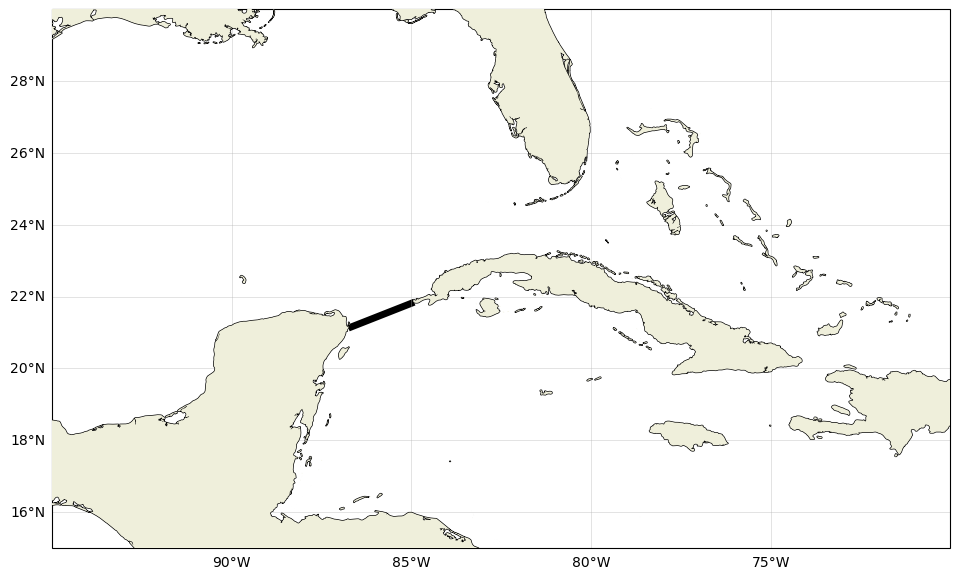

In [39]:

fig, ax = plt.subplots(figsize=(14,7),subplot_kw=dict(projection=cartopy.crs.PlateCarree()))

plt.plot([yucatan.x[-1], yucatan.x[0]], [yucatan.y[-1], yucatan.y[0]],'k', linewidth=5,transform=cartopy.crs.PlateCarree())

ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)
glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
ax.set_ylim(15,30)
ax.set_xlim(-95,-70)

## Interp onto regular depth grid to make the transport calculations smoother

In [40]:
# dz = 1
# grid_depth = np.arange(0.5, np.nanmax(yucatan.depth.values), dz)


# yucatan = yucatan.chunk({'time': -1})

# #yucatan = yucatan.chunk(dict(depth=-1))


# # Define a function that applies np.gradient along the depth dimension
# def interp_along_depth(depth, var, grid_depth):
#     interp_func = interp1d(depth, var, kind='linear',fill_value=np.nan,bounds_error=False)
#     return interp_func(grid_depth)


# # Use xarray's apply_ufunc to interpolate along the depth dimension
# yucatan_uvel_interp = xr.apply_ufunc(
#     interp_along_depth,          # function to apply
#     yucatan['depth'],            # depth array
#     yucatan['uo'],        # cross_vel array
#     grid_depth,                  # additional argument: new depth levels
#     input_core_dims=[['depth'], ['time', 'point', 'depth'], ['grid_depth']],  # specify input dimensions
#     output_core_dims=[['time', 'point', 'grid_depth']],           # specify output dimension
#     vectorize=True,              # vectorize the function
#     dask='parallelized',         # enable parallel computation with dask
#     output_dtypes=[yucatan.uo.dtype]     # output dtype
# )

# # Use xarray's apply_ufunc to interpolate along the depth dimension
# yucatan_vvel_interp = xr.apply_ufunc(
#     interp_along_depth,          # function to apply
#     yucatan['depth'],            # depth array
#     yucatan['vo'],        # cross_vel array
#     grid_depth,                  # additional argument: new depth levels
#     input_core_dims=[['depth'], ['time', 'point', 'depth'], ['grid_depth']],  # specify input dimensions
#     output_core_dims=[['time', 'point', 'grid_depth']],           # specify output dimension
#     vectorize=True,              # vectorize the function
#     dask='parallelized',         # enable parallel computation with dask
#     output_dtypes=[yucatan.uo.dtype]     # output dtype
# )


# # Use xarray's apply_ufunc to interpolate along the depth dimension
# yucatan_absolute_salinity_interp = xr.apply_ufunc(
#     interp_along_depth,          # function to apply
#     yucatan['depth'],            # depth array
#     yucatan['absolute_salinity'],        # cross_vel array
#     grid_depth,                  # additional argument: new depth levels
#     input_core_dims=[['depth'], ['time', 'point', 'depth'], ['grid_depth']],  # specify input dimensions
#     output_core_dims=[['time', 'point', 'grid_depth']],           # specify output dimension
#     vectorize=True,              # vectorize the function
#     dask='parallelized',         # enable parallel computation with dask
#     output_dtypes=[yucatan.uo.dtype]     # output dtype
# )


# # Use xarray's apply_ufunc to interpolate along the depth dimension
# yucatan_conservative_temperature_interp = xr.apply_ufunc(
#     interp_along_depth,          # function to apply
#     yucatan['depth'],            # depth array
#     yucatan['conservative_temperature'],        # cross_vel array
#     grid_depth,                  # additional argument: new depth levels
#     input_core_dims=[['depth'], ['time', 'point', 'depth'], ['grid_depth']],  # specify input dimensions
#     output_core_dims=[['time', 'point', 'grid_depth']],           # specify output dimension
#     vectorize=True,              # vectorize the function
#     dask='parallelized',         # enable parallel computation with dask
#     output_dtypes=[yucatan.uo.dtype]     # output dtype
# )


# # Use xarray's apply_ufunc to interpolate along the depth dimension
# yucatan_potential_density_interp = xr.apply_ufunc(
#     interp_along_depth,          # function to apply
#     yucatan['depth'],            # depth array
#     yucatan['potential_density'],        # cross_vel array
#     grid_depth,                  # additional argument: new depth levels
#     input_core_dims=[['depth'], ['time', 'point', 'depth'], ['grid_depth']],  # specify input dimensions
#     output_core_dims=[['time', 'point', 'grid_depth']],           # specify output dimension
#     vectorize=True,              # vectorize the function
#     dask='parallelized',         # enable parallel computation with dask
#     output_dtypes=[yucatan.uo.dtype]     # output dtype
# )


In [41]:
# # Create a new xarray Dataset with the interpolated data
# yucatan_interp = xr.Dataset(
#     {
#         'conservative_temperature': (['time', 'point', 'depth'], yucatan_conservative_temperature_interp.values),
#         'absolute_salinity': (['time', 'point', 'depth'], yucatan_absolute_salinity_interp.values),
#         'potential_density': (['time', 'point', 'depth'], yucatan_potential_density_interp.values),
#         'uvel': (['time', 'point', 'depth'], yucatan_uvel_interp.values),
#         'vvel': (['time', 'point', 'depth'], yucatan_vvel_interp.values),        
#     },
#     coords={
#         'time': yucatan.time.values,
#         'point': yucatan.point.values,
#         'depth': grid_depth  # Use grid_depth as the new depth dimension
#     }
# )
# yucatan_interp

## Save

In [42]:
# yucatan_interp.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_Yucatan_Straits_Interp.nc')

## Reload

In [205]:
yucatan_interp = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_Yucatan_Straits_Interp.nc')
yucatan_interp

<xarray.Dataset>
Dimensions:                   (time: 373, point: 22, depth: 5728)
Coordinates:
  * time                      (time) datetime64[ns] 1993-01-01 ... 2023-12-01
  * point                     (point) int64 0 1 2 3 4 5 6 ... 16 17 18 19 20 21
  * depth                     (depth) float64 0.5 1.5 ... 5.726e+03 5.728e+03
Data variables:
    conservative_temperature  (time, point, depth) float64 ...
    absolute_salinity         (time, point, depth) float64 ...
    potential_density         (time, point, depth) float64 ...
    cross_vel                 (time, point, depth) float64 ...
    along_vel                 (time, point, depth) float64 ...
    uvel                      (time, point, depth) float64 ...
    vvel                      (time, point, depth) float64 ...

In [206]:
yucatan_transport_per_unit_depth = (yucatan_interp.vvel*yucatan_dx).sum(dim=['point']).mean(dim='time')
yucatan_transport_per_unit_depth.sum()/(10**6)

<xarray.DataArray 'vvel' ()>
array(27.90291456)

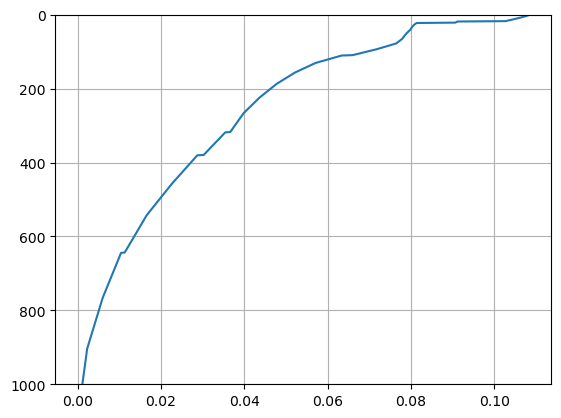

In [207]:
plt.plot(yucatan_transport_per_unit_depth/(10**6),yucatan_transport_per_unit_depth.depth)
plt.ylim(1000,0)
plt.grid()

In [208]:
fs_sill_depth = 760

yucatan_transport_per_unit_depth = yucatan_transport_per_unit_depth[yucatan_transport_per_unit_depth.depth<fs_sill_depth]

In [209]:
yucatan_transport_per_unit_depth.sum()/(10**6)

<xarray.DataArray 'vvel' ()>
array(26.65130243)

## Potential adjustment


## ATL Method:

In [211]:
## Find the maximum depth of finite velocity data in the yucatan straits
#yucatan_vel_max_depth = yucatan_transport_per_unit_depth.depth[np.where(yucatan_transport_per_unit_depth==0)[0][0]].values
## Difference in the transport values between the yucatan straits and greater atlantic
trsp_diff = (-(yucatan_transport_per_unit_depth.sum())-(atl_transport_per_unit_depth.sum())).values
## Find the area of the greater Atlantic that is not nan
atl_finite_depths = np.sum((np.isfinite(glorys_atl_vo_interp_ds.vvel).values==True),axis=0)
atl_area = np.sum(atl_finite_depths*dx)
## divide that transport diff by the depth of the profile to find the adjustment per unit depth
adjustment_per_unit_depth = trsp_diff/atl_area ## m
print('adjustment to N-S velocity of +'+str((np.round(adjustment_per_unit_depth*100,4)))+' cm/s')

adjustment to N-S velocity of +0.0089 cm/s


## adjust

In [212]:
for x in np.arange(0,len(atl_finite_depths)):
    glorys_atl_vo_interp_ds.vvel[0:atl_finite_depths[x]+1,x] = glorys_atl_vo_interp_ds.vvel[0:atl_finite_depths[x]+1,x]+adjustment_per_unit_depth

atl_transport_per_unit_depth = glorys_atl_vo_interp_ds.vvel*dx


## Yucatan Method:

In [203]:
# ## Difference in the transport values between the yucatan straits and greater atlantic
# trsp_diff = (-(yucatan_transport_per_unit_depth.sum())-(atl_transport_per_unit_depth.sum())).values
# ## divide that transport diff by the depth of the profile to find the adjustment per unit depth
# adjustment_per_unit_depth = trsp_diff/(len(yucatan_transport_per_unit_depth)) ## m
# print('adjustment to Yucatan transport of +'+str((np.round(((adjustment_per_unit_depth*(len(yucatan_transport_per_unit_depth)))/yucatan_dx)/(10**6),4)))+' Sv')

In [204]:
# yucatan_transport_per_unit_depth = yucatan_transport_per_unit_depth+adjustment_per_unit_depth

## check mass is balanced now

In [213]:
np.nansum(atl_transport_per_unit_depth)/(10**6)

-26.651306

In [214]:
(yucatan_transport_per_unit_depth.sum().values/(10**6))

26.651302429621527

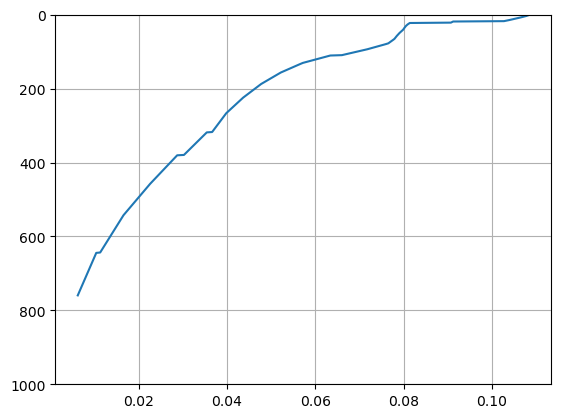

In [215]:
plt.plot(yucatan_transport_per_unit_depth/(10**6),yucatan_transport_per_unit_depth.depth)
plt.ylim(1000,0)
plt.grid()

## Salt Transport

In [216]:
#salt_transport_atl = decadal_ds_interp.absolute_salinity*atl_transport_per_unit_depth
salt_transport_atl = decadal_ds_interp.practical_salinity*atl_transport_per_unit_depth
salt_transport_atl_grid = salt_transport_atl.sum(dim=['latitude','longitude']).load()
salt_transport_atl_grid = salt_transport_atl_grid.rename({'time':'decade'})
salt_transport_atl

<xarray.DataArray (time: 7, depth: 5728, longitude: 763, latitude: 1)>
dask.array<mul, shape=(7, 5728, 763, 1), dtype=float64, chunksize=(7, 5728, 763, 1), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 21.5
  * time       (time) int64 1960 1970 1980 1990 2000 2010 2020
  * depth      (depth) float64 0.5 1.5 2.5 3.5 ... 5.726e+03 5.726e+03 5.728e+03
  * longitude  (longitude) float32 -77.5 -77.42 -77.33 ... -14.17 -14.08 -14.0

## Heat Transport

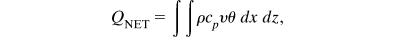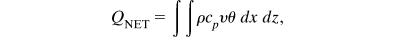

In [217]:
rho_Cp =  4.1 * (10**6) ## From Johns et al. (2011) [J/(kg*C)]
#heat_transport_atl = decadal_ds_interp.conservative_temperature*atl_transport_per_unit_depth*rho_Cp
heat_transport_atl = decadal_ds_interp.potential_temp*atl_transport_per_unit_depth*rho_Cp
heat_transport_atl_grid = heat_transport_atl.sum(dim=['latitude','longitude']).load()
heat_transport_atl_grid = heat_transport_atl_grid.rename({'time':'decade'})
heat_transport_atl = heat_transport_atl.rename({'time':'decade'})
heat_transport_atl

<xarray.DataArray (decade: 7, depth: 5728, longitude: 763, latitude: 1)>
dask.array<mul, shape=(7, 5728, 763, 1), dtype=float64, chunksize=(7, 5728, 763, 1), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 21.5
  * decade     (decade) int64 1960 1970 1980 1990 2000 2010 2020
  * depth      (depth) float64 0.5 1.5 2.5 3.5 ... 5.726e+03 5.726e+03 5.728e+03
  * longitude  (longitude) float32 -77.5 -77.42 -77.33 ... -14.17 -14.08 -14.0

In [363]:
decadal_ds_interp

<xarray.Dataset>
Dimensions:                   (time: 7, depth: 5728, longitude: 763, latitude: 1)
Coordinates:
  * latitude                  (latitude) float64 21.5
  * time                      (time) int64 1960 1970 1980 1990 2000 2010 2020
  * depth                     (depth) float64 0.5 1.5 ... 5.726e+03 5.728e+03
  * longitude                 (longitude) float32 -77.5 -77.42 ... -14.08 -14.0
Data variables:
    conservative_temperature  (time, depth, longitude, latitude) float64 dask.array<chunksize=(7, 5728, 763, 1), meta=np.ndarray>
    absolute_salinity         (time, depth, longitude, latitude) float64 dask.array<chunksize=(7, 5728, 763, 1), meta=np.ndarray>
    num_profs                 (time, longitude, latitude) float64 dask.array<chunksize=(7, 763, 1), meta=np.ndarray>
    potential_density         (time, depth, longitude, latitude) float64 dask.array<chunksize=(7, 5728, 763, 1), meta=np.ndarray>
    potential_temp            (time, depth, longitude, latitude) float64 dask.array<chunksize=(7, 5728, 763, 1), meta=np.ndarray>
    practical_salinity        (time, depth, longitude, latitude) float64 dask.array<chunksize=(7, 5728, 763, 1), meta=np.ndarray>

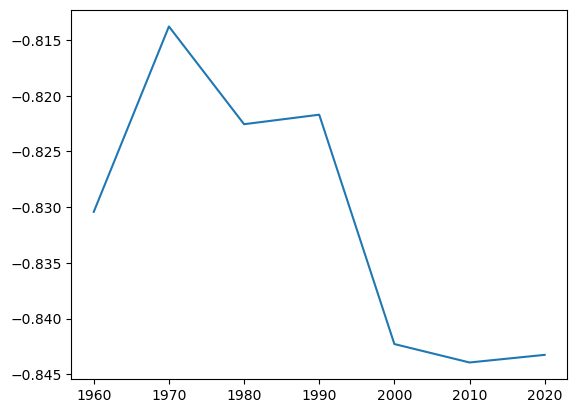

In [218]:
plt.plot(heat_transport_atl.decade,heat_transport_atl.sum(dim=['depth','longitude','latitude']).values/(10**15))

## Load water mass property trend data

In [219]:
decadal_mean_ds_ctf = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/EN4_CTF_1960_2020_Mean_Decadal_Profiles_Trends.nc')

## Make same depth as the transport ds
dz = 1
grid_depth = np.arange(0.5, glorys_atl.depth.max().values, dz)

def depth_interp(old_depth,vel,new_depth):
    interp_func = interp1d(old_depth, vel, kind='linear')
    return interp_func(new_depth)


# Apply the function using xarray's apply_ufunc
decadal_mean_ds_ctf = xr.apply_ufunc(
    depth_interp,                            # function to apply
    decadal_mean_ds_ctf.depth,                           # additional argument to pass to the function
    decadal_mean_ds_ctf,                        # additional argument to pass to the function
    grid_depth,                              # input array
    input_core_dims=[['depth'], ['depth'],['new_depth']],  # core dimensions for input arrays
    output_core_dims=[['new_depth']],            # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[glorys_atl.vo.dtype]      # output dtype
)

decadal_mean_ds_ctf = decadal_mean_ds_ctf.rename({'new_depth':'depth'})
decadal_mean_ds_ctf['depth'] = grid_depth

## convert CT and AS to PT and PSU
decadal_mean_ds_ctf['potential_temp'] = gsw.pt_from_CT(decadal_mean_ds_ctf.salt, decadal_mean_ds_ctf.temp)
decadal_mean_ds_ctf['practical_salinity'] = gsw.SP_from_SA(decadal_mean_ds_ctf.salt, gsw.p_from_z(-decadal_mean_ds_ctf.depth,15),-70,15)
decadal_mean_ds_ctf = decadal_mean_ds_ctf.transpose()
decadal_mean_ds_ctf

<xarray.Dataset>
Dimensions:             (decade: 7, depth: 5728)
Coordinates:
  * decade              (decade) int64 1960 1970 1980 1990 2000 2010 2020
  * depth               (depth) float64 0.5 1.5 2.5 ... 5.726e+03 5.728e+03
Data variables:
    temp                (depth, decade) float32 27.42 27.25 27.41 ... nan nan
    salt                (depth, decade) float32 35.84 35.87 35.99 ... nan nan
    temp_slope          (depth) float32 0.02264 0.02187 0.02111 ... nan nan nan
    salt_slope          (depth) float32 -0.01231 -0.01042 -0.008539 ... nan nan
    temp_p_val          (depth) float32 0.06464 0.05247 0.0403 ... nan nan nan
    salt_p_val          (depth) float32 0.07807 0.1576 0.2372 ... nan nan nan
    temp_e              (depth) float32 0.009525 0.008463 0.0074 ... nan nan nan
    salt_e              (depth) float32 0.004722 0.004677 0.004633 ... nan nan
    potential_temp      (depth, decade) float64 27.44 27.27 27.44 ... nan nan
    practical_salinity  (depth, decade) float64 35.68 35.7 35.82 ... nan nan nan

## Make sure any data below the Yucatan sill depth is nan

In [220]:
# sill_ind = np.max(np.where(yucatan_transport_per_unit_depth>0)[0])
# sill_depth = yucatan_transport_per_unit_depth.depth[sill_ind].values ## 1940 m due to resolution of pre-interpolated GLORYS
# sill_depth

## Make sure any data below the FS sill depth is nan

In [221]:
sill_depth = np.max(yucatan_transport_per_unit_depth.depth)
sill_depth

<xarray.DataArray 'depth' ()>
array(759.5)

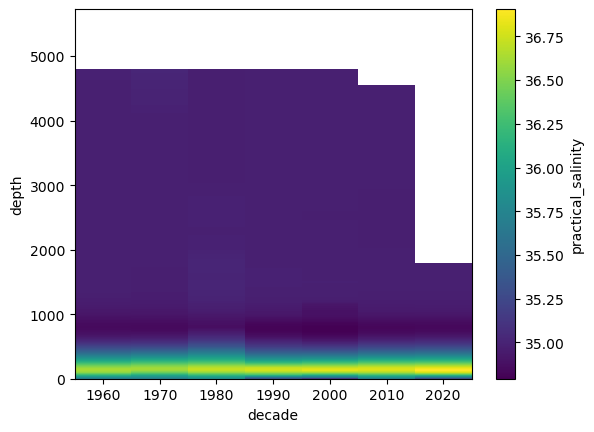

In [222]:
decadal_mean_ds_ctf.practical_salinity.plot()

In [223]:
### This for when doing yucatan sill depth
#decadal_mean_ds_ctf = decadal_mean_ds_ctf.where(decadal_mean_ds_ctf.depth<sill_depth, np.nan)
### This for when doing FC sill depth
decadal_mean_ds_ctf = decadal_mean_ds_ctf.where(decadal_mean_ds_ctf.depth<=sill_depth, drop=True)

decadal_mean_ds_ctf = decadal_mean_ds_ctf.combine_first(decadal_mean_ds_ctf.mean(dim='decade'))

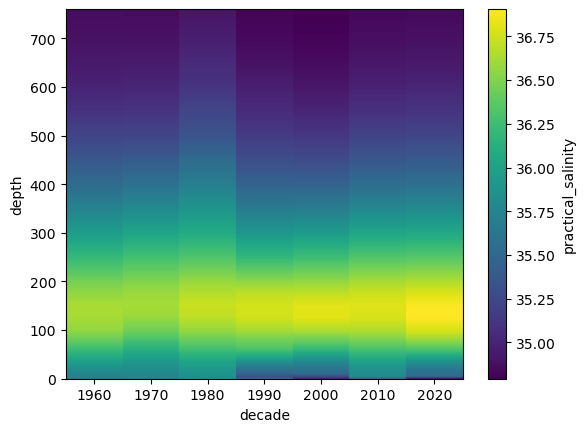

In [224]:
decadal_mean_ds_ctf.practical_salinity.plot()

## Reshape

In [225]:
#yucatan_transport_per_unit_depth_reindexed = yucatan_transport_per_unit_depth.interp_like(decadal_mean_ds_ctf)
yucatan_transport_per_unit_depth_repeated = np.tile(yucatan_transport_per_unit_depth, (len(decadal_mean_ds_ctf.decade),1)).transpose()

In [226]:
#decadal_mean_ds_ctf = decadal_mean_ds_ctf.interp_like(yucatan_transport_per_unit_depth)

In [227]:
#heat_transport_ctf = decadal_mean_ds_ctf.temp*yucatan_transport_per_unit_depth_repeated*rho_Cp

heat_transport_ctf = decadal_mean_ds_ctf.potential_temp*yucatan_transport_per_unit_depth_repeated*rho_Cp

In [285]:
(decadal_mean_ds_ctf.temp_slope*yucatan_transport_per_unit_depth*rho_Cp).sum()

<xarray.DataArray ()>
array(1.07658319e+12)

In [362]:
heat_transport_atl

<xarray.DataArray (decade: 7, depth: 5728, longitude: 763, latitude: 1)>
dask.array<mul, shape=(7, 5728, 763, 1), dtype=float64, chunksize=(7, 5728, 763, 1), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 21.5
  * decade     (decade) int64 1960 1970 1980 1990 2000 2010 2020
  * depth      (depth) float64 0.5 1.5 2.5 3.5 ... 5.726e+03 5.726e+03 5.728e+03
  * longitude  (longitude) float32 -77.5 -77.42 -77.33 ... -14.17 -14.08 -14.0

(2000.0, 0.0)

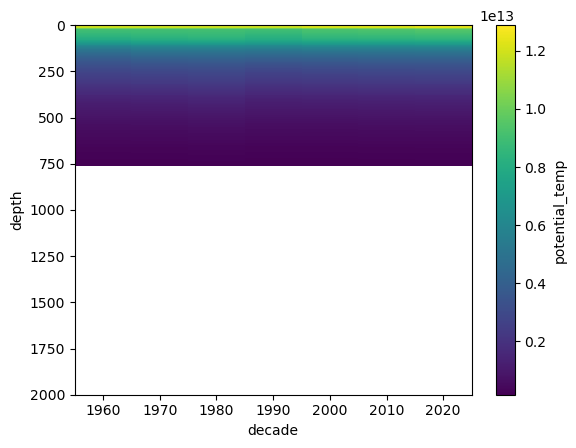

In [228]:
heat_transport_ctf.plot()
plt.ylim(2000,0)

## Look at error in trends in heat transport on depth levels?

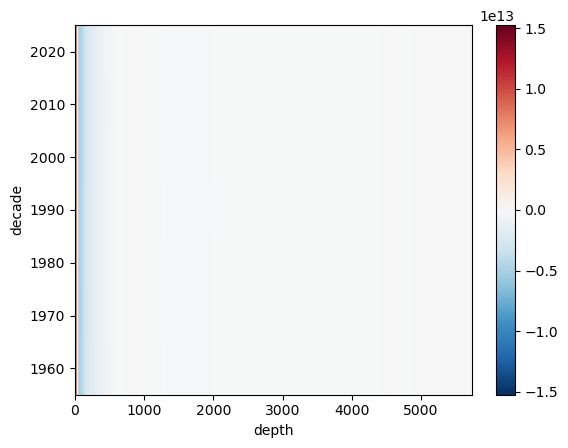

In [229]:
heat_transport_atl.sum(dim=['longitude','latitude']).plot()

In [230]:
net_heat_transport_grid = heat_transport_ctf+heat_transport_atl_grid
net_heat_transport_grid

<xarray.DataArray (depth: 760, decade: 7)>
array([[2.49226477e+13, 2.45449235e+13, 2.47953665e+13, ...,
        2.54949557e+13, 2.51865222e+13, 2.58335775e+13],
       [2.58503557e+13, 2.55544000e+13, 2.58112150e+13, ...,
        2.63546726e+13, 2.61599813e+13, 2.67136085e+13],
       [2.63386120e+13, 2.61136222e+13, 2.63724036e+13, ...,
        2.67858839e+13, 2.67053784e+13, 2.71657062e+13],
       ...,
       [2.20565919e+11, 2.29992189e+11, 2.40771776e+11, ...,
        2.13309649e+11, 2.26597482e+11, 2.28788755e+11],
       [2.19914995e+11, 2.29505633e+11, 2.40112351e+11, ...,
        2.12971808e+11, 2.26115028e+11, 2.28219844e+11],
       [2.19264357e+11, 2.29019549e+11, 2.39454278e+11, ...,
        2.12633984e+11, 2.25632470e+11, 2.27650968e+11]])
Coordinates:
  * decade   (decade) int64 1960 1970 1980 1990 2000 2010 2020
  * depth    (depth) float64 0.5 1.5 2.5 3.5 4.5 ... 756.5 757.5 758.5 759.5

In [231]:
def slope_and_CI(x,y):
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # Number of observations
    n = len(x)
    
    # Standard error of the slope
    slope_std_err = std_err
    
    # Residuals
    residuals = y - (slope * x + intercept)
    
    # Residual standard error
    residual_std_err = np.sqrt(np.sum(residuals**2) / (n - 2))
    
    # Standard error of the intercept
    x_mean = np.mean(x)
    intercept_std_err = residual_std_err * np.sqrt(np.sum(x**2) / (n * np.sum((x - x_mean)**2)))
    
    # Confidence interval calculation
    t_val = stats.t.ppf(0.975, n - 2)  # t critical value for 95% confidence
    
    # Confidence intervals for slope and intercept
    slope_ci = (slope - t_val * slope_std_err, slope + t_val * slope_std_err)
    intercept_ci = (intercept - t_val * intercept_std_err, intercept + t_val * intercept_std_err)
    return slope, slope_ci[0], slope_ci[1]
    #print(f"Slope: {slope} ({slope_ci[0]}, {slope_ci[1]})")
    #print(f"Intercept: {intercept} ({intercept_ci[0]}, {intercept_ci[1]})")


heat_transport_ctf_slope = np.empty(len(heat_transport_ctf.depth))
heat_transport_ctf_slope[:] = np.nan
heat_transport_ctf_slope_ci1 = np.empty(len(heat_transport_ctf.depth))
heat_transport_ctf_slope_ci1[:] = np.nan
heat_transport_ctf_slope_ci2 = np.empty(len(heat_transport_ctf.depth))
heat_transport_ctf_slope_ci2[:] = np.nan

heat_transport_atl_slope = np.empty(len(heat_transport_ctf.depth))
heat_transport_atl_slope[:] = np.nan
heat_transport_atl_slope_ci1 = np.empty(len(heat_transport_ctf.depth))
heat_transport_atl_slope_ci1[:] = np.nan
heat_transport_atl_slope_ci2 = np.empty(len(heat_transport_ctf.depth))
heat_transport_atl_slope_ci2[:] = np.nan

heat_transport_net_slope = np.empty(len(heat_transport_ctf.depth))
heat_transport_net_slope[:] = np.nan
heat_transport_net_slope_ci1 = np.empty(len(heat_transport_ctf.depth))
heat_transport_net_slope_ci1[:] = np.nan
heat_transport_net_slope_ci2 = np.empty(len(heat_transport_ctf.depth))
heat_transport_net_slope_ci2[:] = np.nan

for depth_ind in np.arange(0,len(heat_transport_ctf)):
    heat_transport_ctf_slope[depth_ind], heat_transport_ctf_slope_ci1[depth_ind], heat_transport_ctf_slope_ci2[depth_ind] = slope_and_CI(heat_transport_ctf.decade.values, heat_transport_ctf.isel(depth=depth_ind).values)
    heat_transport_atl_slope[depth_ind], heat_transport_atl_slope_ci1[depth_ind], heat_transport_atl_slope_ci2[depth_ind] = slope_and_CI(heat_transport_atl_grid.decade.values, heat_transport_atl_grid.isel(depth=depth_ind).values)
    heat_transport_net_slope[depth_ind], heat_transport_net_slope_ci1[depth_ind], heat_transport_net_slope_ci2[depth_ind] = slope_and_CI(net_heat_transport_grid.decade.values, net_heat_transport_grid.isel(depth=depth_ind).values)


In [232]:
# plt.figure(figsize=(8,8))
# plt.plot(heat_transport_ctf_slope/(10**15),heat_transport_ctf.depth,color='tab:blue',label='CTF')
# plt.fill_betweenx(heat_transport_ctf.depth,heat_transport_ctf_slope_ci1/(10**15),heat_transport_ctf_slope_ci2/(10**15),alpha=0.3,color='tab:blue')

# plt.plot(heat_transport_atl_slope/(10**15),heat_transport_atl_grid.depth,color='tab:orange',label='ATL')
# plt.fill_betweenx(heat_transport_atl_grid.depth,heat_transport_atl_slope_ci1/(10**15),heat_transport_atl_slope_ci2/(10**15),alpha=0.3,color='tab:orange')

# plt.ylim(1800,0)
# plt.xlim(-0.000005,0.00002)
# plt.grid()
# plt.legend()
# plt.ylabel('Depth [m]')
# plt.xlabel('Heat Transport [PW]')

In [233]:
# plt.figure(figsize=(8,8))
# plt.plot(heat_transport_net_slope/(10**15),net_heat_transport_grid.depth,color='green',label='Net')
# plt.fill_betweenx(net_heat_transport_grid.depth,heat_transport_net_slope_ci1/(10**15),heat_transport_net_slope_ci2/(10**15),alpha=0.3,color='green')

# plt.ylim(1800,0)
# plt.xlim(-0.000005,0.00002)
# plt.grid()
# plt.legend()
# plt.ylabel('Depth [m]')
# plt.xlabel('Heat Transport [PW]')

## Find where heat transport CI does NOT overlap with 0

In [234]:
# def is_zero_between(a, b):
#     return (a < 0 < b) or (b < 0 < a)

# ## find where heat transport trend CI does NOT overlap with 0
# net_heat_transport_trend_depth_inds = np.empty(len(heat_transport_ctf.depth))
# net_heat_transport_trend_depth_inds[:] = 0

# ctf_heat_transport_trend_depth_inds = np.empty(len(heat_transport_ctf.depth))
# ctf_heat_transport_trend_depth_inds[:] = 0

# atl_heat_transport_trend_depth_inds = np.empty(len(heat_transport_ctf.depth))
# atl_heat_transport_trend_depth_inds[:] = 0

# for x in np.arange(0,len(heat_transport_ctf.depth)):
#     net_heat_transport_trend_depth_inds[x] = is_zero_between(heat_transport_net_slope_ci1[x],heat_transport_net_slope_ci2[x])
#     ctf_heat_transport_trend_depth_inds[x] = is_zero_between(heat_transport_ctf_slope_ci1[x],heat_transport_ctf_slope_ci2[x])
#     atl_heat_transport_trend_depth_inds[x] = is_zero_between(heat_transport_atl_slope_ci1[x],heat_transport_atl_slope_ci2[x])
    

## 1's represent true, as in zero lies between CI

In [235]:
# plt.plot(net_heat_transport_trend_depth_inds,heat_transport_ctf.depth)
# plt.ylim(3000,0)

In [236]:
# plt.plot(net_heat_transport_grid.decade,heat_transport_atl_grid[:,np.where(atl_heat_transport_trend_depth_inds==0)[0]].sum(dim='depth')/(10**15))
# plt.scatter(net_heat_transport_grid.decade,(heat_transport_atl_grid[:,np.where(atl_heat_transport_trend_depth_inds==0)[0]].sum(dim='depth')/(10**15)))
# plt.grid()
# plt.ylabel('ATL Heat Transport [PW]')
# plt.title('ATL Heat Transport from depths with statistically non-zero trends')

In [237]:
# linregress(net_heat_transport_grid.decade,heat_transport_atl_grid[:,np.where(atl_heat_transport_trend_depth_inds==0)[0]].sum(dim='depth'),alternative='greater')


In [238]:
# plt.plot(net_heat_transport_grid.decade,heat_transport_ctf[np.where(ctf_heat_transport_trend_depth_inds==0)[0],:].sum(dim='depth')/(10**15))
# plt.scatter(net_heat_transport_grid.decade,(heat_transport_ctf[np.where(ctf_heat_transport_trend_depth_inds==0)[0],:].sum(dim='depth')/(10**15)))
# plt.grid()
# plt.ylabel('CTF Heat Transport [PW]')
# plt.title('CTF Heat Transport from depths with statistically non-zero trends')

In [239]:
# linregress(net_heat_transport_grid.decade,heat_transport_ctf[np.where(ctf_heat_transport_trend_depth_inds==0)[0],:].sum(dim='depth'),alternative='greater')


In [240]:
# plt.plot(net_heat_transport_grid.decade,net_heat_transport_grid[np.where(net_heat_transport_trend_depth_inds==0)[0],:].sum(dim='depth')/(10**15))
# plt.scatter(net_heat_transport_grid.decade,(net_heat_transport_grid[np.where(net_heat_transport_trend_depth_inds==0)[0],:].sum(dim='depth')/(10**15)))
# plt.grid()
# plt.ylabel('Net Heat Transport [PW]')
# plt.title('Net Heat Transport from depths with statistically non-zero trends')

In [241]:
# linregress(net_heat_transport_grid.decade,net_heat_transport_grid[np.where(net_heat_transport_trend_depth_inds==0)[0],:].sum(dim='depth'),alternative='greater')


In [242]:
# slope_and_CI(net_heat_transport_grid.decade,net_heat_transport_grid[np.where(net_heat_transport_trend_depth_inds==0)[0],:].sum(dim='depth'))

## Net Heat Transport

In [243]:
net_heat_transport = (heat_transport_ctf.sum(dim='depth') + heat_transport_atl.sum(dim=['depth','longitude','latitude']))/(10**15)

Text(0.5, 0, '')

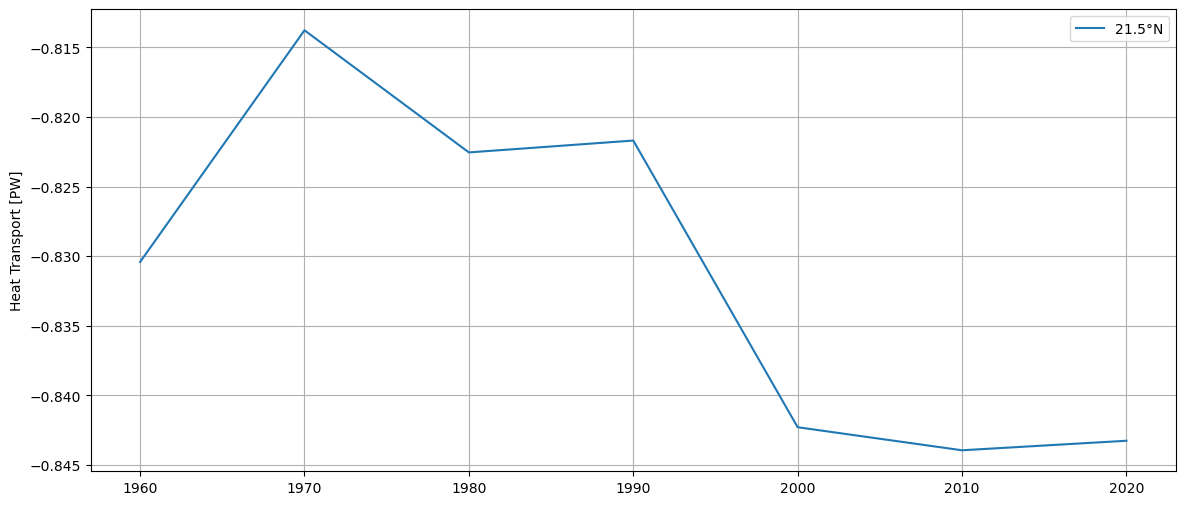

In [343]:
plt.figure(figsize=(14,6))
#net_heat_transport.plot(label='Net')
#(heat_transport_ctf.sum(dim='depth')/(10**15)).plot(label='CTF')
(heat_transport_atl.sum(dim=['depth','longitude','latitude'])/(10**15)).plot(label='21.5°N')
plt.grid()
plt.legend()
#plt.ylim(1.1,1.4)
plt.ylabel('Heat Transport [PW]')
plt.xlabel('')

In [348]:
import scipy
scipy.stats.pearsonr(heat_transport_ctf.sum(dim='depth'), net_heat_transport)


PearsonRResult(statistic=0.9489006361926544, pvalue=0.0011028059170389492)

In [349]:
scipy.stats.pearsonr(heat_transport_atl.sum(dim=['depth','longitude','latitude']), net_heat_transport)


PearsonRResult(statistic=-0.07207610876751393, pvalue=0.8779573781417992)

In [329]:
linregress(net_heat_transport.decade,net_heat_transport.values)

LinregressResult(slope=0.0006558870391288488, intercept=-0.0299191352343946, rvalue=0.39515982433765146, pvalue=0.3802817188358898, stderr=0.0006818731024210403, intercept_stderr=1.3569960020474892)

In [340]:
linregress(net_heat_transport.decade,heat_transport_ctf.sum(dim='depth').values)
1079512362711.9464/(10**14)

0.010795123627119464

In [341]:
0.010795123627119464

0.06477074176271679

In [338]:
(heat_transport_ctf.sum(dim='depth').values[-1]-heat_transport_ctf.sum(dim='depth').values[0])/(10**15)

0.0965349717320755

## Look at the upper 300m where there are meaningful trends in water mass properties!

In [246]:
surf_heat_transport_ctf = heat_transport_ctf.where(heat_transport_ctf.depth<=300,drop=True)
surf_heat_transport_atl = heat_transport_atl.where(heat_transport_atl.depth<=300,drop=True)

decadal_slope_surf_ctf_heat_transport, decadal_intercept_surf_ctf_heat_transport, decadal_r_surf_ctf_heat_transport, decadal_p_surf_ctf_heat_transport, decadal_e_surf_ctf_heat_transport = linregress(surf_heat_transport_ctf.decade.values, surf_heat_transport_ctf.sum(dim='depth')/(10**15))

trend_surf_ctf_heat_transport = decadal_intercept_surf_ctf_heat_transport + decadal_slope_surf_ctf_heat_transport*surf_heat_transport_ctf.decade.values


# Fit x to y
p_surf_heat_transport_ctf, y_err_surf_heat_transport_ctf = lin_fit(surf_heat_transport_ctf.decade.values, surf_heat_transport_ctf.sum(dim='depth').values/(10**15))
# Calculate confidence intervals
p_x_surf_heat_transport_ctf, confs_surf_heat_transport_ctf = conf_calc(surf_heat_transport_ctf.decade.values, y_err_surf_heat_transport_ctf, 0.975)
# The fit line, and lower and upper confidence bounds
p_y_surf_heat_transport_ctf, lower_surf_heat_transport_ctf, upper_surf_heat_transport_ctf = ylines_calc(p_x_surf_heat_transport_ctf, confs_surf_heat_transport_ctf, p_surf_heat_transport_ctf)

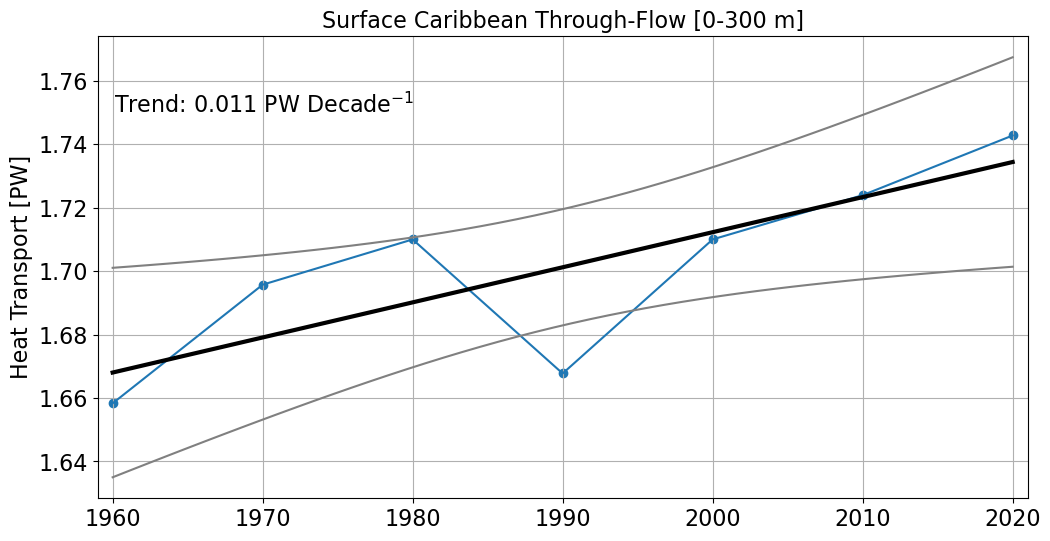

In [281]:
font_size = 16

plt.figure(figsize=(12,6))
plt.plot(heat_transport_ctf.decade.values,surf_heat_transport_ctf.sum(dim='depth')/(10**15))
plt.scatter(heat_transport_ctf.decade.values,surf_heat_transport_ctf.sum(dim='depth')/(10**15))
plt.grid()
plt.ylabel('Heat Transport [PW]',fontsize=font_size)
#plt.ylim(1.62,1.8)
plt.xlim(1959,2021)
plt.title('Surface Caribbean Through-Flow [0-300 m]',fontsize=font_size)

plt.plot(heat_transport_ctf.decade.values,trend_surf_ctf_heat_transport,color='black',linewidth=3)
plt.plot(p_x_surf_heat_transport_ctf, lower_surf_heat_transport_ctf, color='grey')
plt.plot(p_x_surf_heat_transport_ctf, upper_surf_heat_transport_ctf, color='grey')

plt.text(1960.1,1.75,'Trend: '+str(np.round(decadal_slope_surf_ctf_heat_transport*10,3))+' PW Decade$^{-1}$',size=font_size,color='black')

plt.gca().tick_params(axis='both', which='major', labelsize=font_size)


## Compare salt transport

In [248]:
#salt_transport_ctf = decadal_mean_ds_ctf.salt*yucatan_transport_per_unit_depth_repeated
salt_transport_ctf = decadal_mean_ds_ctf.practical_salinity*yucatan_transport_per_unit_depth_repeated
net_salt_transport = salt_transport_ctf.sum(dim='depth') + salt_transport_atl.sum(dim=['depth','longitude','latitude']).values
(net_salt_transport/(10**6)).mean()

<xarray.DataArray 'practical_salinity' ()>
array(52.74471626)

Text(0.5, 0, '')

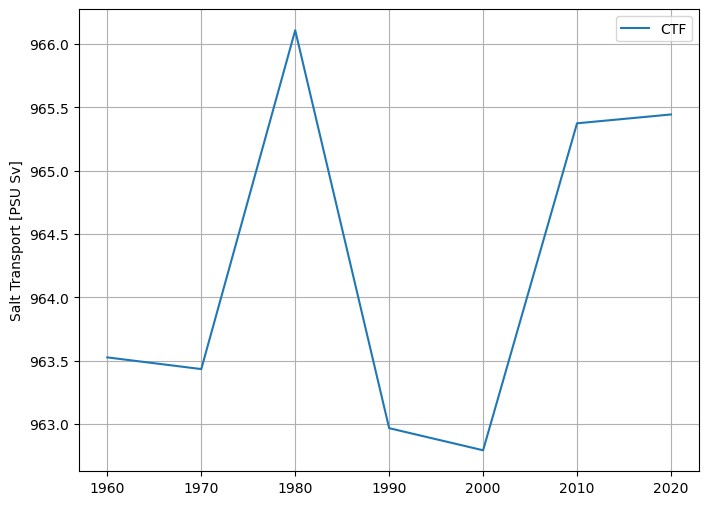

In [361]:
plt.figure(figsize=(8,6))
#(net_salt_transport/(10**6)).plot(label='Net')
(salt_transport_ctf.sum(dim='depth')/(10**6)).plot(label='CTF')
#(-salt_transport_atl.sum(dim=['depth','longitude','latitude'])/(10**6)).plot(label='21.5°N')
plt.grid()
plt.legend()
#plt.ylim(1.1,1.4)
plt.ylabel('Salt Transport [PSU Sv]')
plt.xlabel('')

In [350]:
scipy.stats.pearsonr(salt_transport_atl.sum(dim=['depth','longitude','latitude']), net_salt_transport)


PearsonRResult(statistic=0.2117029476806691, pvalue=0.6486012542074212)

In [353]:
scipy.stats.pearsonr(salt_transport_ctf.sum(dim='depth'), net_salt_transport)


PearsonRResult(statistic=0.9705181963344367, pvalue=0.000282127269845376)

In [352]:
salt_transport_ctf

<xarray.DataArray 'salt' (depth: 760, decade: 7)>
array([[3881126.52090674, 3884068.25274255, 3897257.71932232, ...,
        3808030.55660067, 3861930.50218483, 3801229.71207994],
       [3880191.29396195, 3882976.13318694, 3895456.30802384, ...,
        3812768.13190146, 3867209.9636523 , 3812979.07955102],
       [3874093.04893036, 3876717.67551483, 3888473.28321993, ...,
        3812418.8565175 , 3867328.76405795, 3819623.60070213],
       ...,
       [ 219853.61262293,  219825.21550642,  220160.35415716, ...,
         219442.14175682,  219714.9791452 ,  219762.74663882],
       [ 218576.94308639,  218548.73447111,  218877.81117796, ...,
         218169.62020365,  218439.99442504,  218487.10400279],
       [ 217300.31554619,  217272.2951544 ,  217595.31063368, ...,
         216897.0964286 ,  217165.04142504,  217211.4738648 ]])
Coordinates:
  * decade   (decade) int64 1960 1970 1980 1990 2000 2010 2020
  * depth    (depth) float64 0.5 1.5 2.5 3.5 4.5 ... 756.5 757.5 758.5 759.5

In [355]:
linregress(net_salt_transport.decade,salt_transport_ctf.sum(dim='depth'))


LinregressResult(slope=22559.108213326333, intercept=919342964.7363673, rvalue=0.35836958665385893, pvalue=0.42991553049072545, stderr=26281.928224471005, intercept_stderr=52303678.499821894)

In [360]:
0.022559108213326334*6

0.135354649279958

In [302]:
(salt_transport_ctf.sum(dim='depth')/(10**6)).std()

<xarray.DataArray 'salt' ()>
array(1.25898564)

In [253]:
net_salt_transport_grid = salt_transport_ctf+salt_transport_atl_grid
net_salt_transport_grid

<xarray.DataArray (depth: 760, decade: 7)>
array([[8158869.76039909, 8156776.64320085, 8164660.6110204 , ...,
        8072669.43639828, 8126664.05225076, 8066961.15341377],
       [8523431.04081556, 8520743.38076228, 8530304.38793236, ...,
        8445940.12997811, 8501727.81742673, 8449106.95939096],
       [8722412.74568113, 8719246.94307597, 8730071.89940034, ...,
        8653694.53612923, 8711046.18622763, 8665469.70438355],
       ...,
       [ 269691.22329893,  269915.6900075 ,  270179.88320673, ...,
         269503.81422187,  269941.62250713,  270070.13051885],
       [ 269164.34757114,  269405.88042453,  269666.3200019 , ...,
         268989.20438253,  269423.18420597,  269548.4683729 ],
       [ 268637.4397442 ,  268896.07928924,  269152.74329295, ...,
         268474.53167082,  268904.70553948,  269026.74071216]])
Coordinates:
  * decade   (decade) int64 1960 1970 1980 1990 2000 2010 2020
  * depth    (depth) float64 0.5 1.5 2.5 3.5 4.5 ... 756.5 757.5 758.5 759.5

In [254]:
# salt_transport_ctf_slope = np.empty(len(salt_transport_ctf.depth))
# salt_transport_ctf_slope[:] = np.nan
# salt_transport_ctf_slope_ci1 = np.empty(len(salt_transport_ctf.depth))
# salt_transport_ctf_slope_ci1[:] = np.nan
# salt_transport_ctf_slope_ci2 = np.empty(len(salt_transport_ctf.depth))
# salt_transport_ctf_slope_ci2[:] = np.nan

# salt_transport_atl_slope = np.empty(len(salt_transport_ctf.depth))
# salt_transport_atl_slope[:] = np.nan
# salt_transport_atl_slope_ci1 = np.empty(len(salt_transport_ctf.depth))
# salt_transport_atl_slope_ci1[:] = np.nan
# salt_transport_atl_slope_ci2 = np.empty(len(salt_transport_ctf.depth))
# salt_transport_atl_slope_ci2[:] = np.nan

# salt_transport_net_slope = np.empty(len(salt_transport_ctf.depth))
# salt_transport_net_slope[:] = np.nan
# salt_transport_net_slope_ci1 = np.empty(len(salt_transport_ctf.depth))
# salt_transport_net_slope_ci1[:] = np.nan
# salt_transport_net_slope_ci2 = np.empty(len(salt_transport_ctf.depth))
# salt_transport_net_slope_ci2[:] = np.nan

# for depth_ind in np.arange(0,len(salt_transport_ctf.depth)):
#     salt_transport_ctf_slope[depth_ind], salt_transport_ctf_slope_ci1[depth_ind], salt_transport_ctf_slope_ci2[depth_ind] = slope_and_CI(salt_transport_ctf.decade.values, salt_transport_ctf.isel(depth=depth_ind).values)
#     salt_transport_atl_slope[depth_ind], salt_transport_atl_slope_ci1[depth_ind], salt_transport_atl_slope_ci2[depth_ind] = slope_and_CI(salt_transport_atl_grid.decade.values, salt_transport_atl_grid.isel(depth=depth_ind).values)
#     salt_transport_net_slope[depth_ind], salt_transport_net_slope_ci1[depth_ind], salt_transport_net_slope_ci2[depth_ind] = slope_and_CI(net_salt_transport_grid.decade.values, net_salt_transport_grid.isel(depth=depth_ind).values)


In [255]:
# plt.figure(figsize=(8,8))
# plt.plot(salt_transport_ctf_slope/(10**6),salt_transport_ctf.depth,color='tab:blue',label='CTF')
# plt.fill_betweenx(salt_transport_ctf.depth,salt_transport_ctf_slope_ci1/(10**6),salt_transport_ctf_slope_ci2/(10**6),alpha=0.3,color='tab:blue')

# plt.plot(salt_transport_atl_slope/(10**6),salt_transport_atl_grid.depth,color='tab:orange',label='ATL')
# plt.fill_betweenx(salt_transport_atl_grid.depth,salt_transport_atl_slope_ci1/(10**6),salt_transport_atl_slope_ci2/(10**6),alpha=0.3,color='tab:orange')

# plt.ylim(1800,0)
# plt.xlim(-0.0005,0.0005)
# plt.grid()
# plt.legend()
# plt.ylabel('Depth [m]')
# plt.xlabel('Salt Transport [PSU Sv]')

In [161]:
# plt.figure(figsize=(8,8))
# plt.plot(salt_transport_net_slope/(10**6),net_salt_transport_grid.depth,color='green',label='Net')
# plt.fill_betweenx(net_salt_transport_grid.depth,salt_transport_net_slope_ci1/(10**6),salt_transport_net_slope_ci2/(10**6),alpha=0.3,color='green')

# plt.ylim(2000,0)
# plt.xlim(-0.001,0.001)
# plt.grid()
# plt.legend()
# plt.ylabel('Depth [m]')
# plt.xlabel('Salt Transport [PSU Sv]')

## Find where heat transport CI does NOT overlap with 0

In [162]:
# def is_zero_between(a, b):
#     return (a < 0 < b) or (b < 0 < a)

# ## find where heat transport trend CI does NOT overlap with 0
# ctf_salt_transport_trend_depth_inds = np.empty(len(salt_transport_ctf.depth))
# ctf_salt_transport_trend_depth_inds[:] = 1
# atl_salt_transport_trend_depth_inds = np.empty(len(salt_transport_ctf.depth))
# atl_salt_transport_trend_depth_inds[:] = 1
# net_salt_transport_trend_depth_inds = np.empty(len(salt_transport_ctf.depth))
# net_salt_transport_trend_depth_inds[:] = 1

# for x in np.arange(0,len(salt_transport_ctf.depth)):
#     net_salt_transport_trend_depth_inds[x] = is_zero_between(salt_transport_net_slope_ci1[x],salt_transport_net_slope_ci2[x])
#     ctf_salt_transport_trend_depth_inds[x] = is_zero_between(salt_transport_ctf_slope_ci1[x],salt_transport_ctf_slope_ci2[x])
#     atl_salt_transport_trend_depth_inds[x] = is_zero_between(salt_transport_atl_slope_ci1[x],salt_transport_atl_slope_ci2[x])
    

## 1's represent true, as in zero lies between CI

In [163]:
# plt.plot(net_salt_transport_trend_depth_inds,salt_transport_ctf.depth)
# plt.plot(ctf_salt_transport_trend_depth_inds,salt_transport_ctf.depth)
# plt.plot(atl_salt_transport_trend_depth_inds,salt_transport_ctf.depth)
# plt.ylim(3000,0)

In [164]:
# plt.plot(salt_transport_ctf.decade,salt_transport_ctf[np.where(ctf_salt_transport_trend_depth_inds==0)[0],:].sum(dim='depth')/(10**6))
# plt.scatter(salt_transport_ctf.decade,(salt_transport_ctf[np.where(ctf_salt_transport_trend_depth_inds==0)[0],:].sum(dim='depth')/(10**6)))
# plt.grid()
# plt.ylabel('CTF Salt Transport [PSU Sv]')
# plt.title('CTF Salt Transport from depths with statistically non-zero trends')

In [165]:
# linregress(salt_transport_ctf.decade,salt_transport_ctf[np.where(ctf_salt_transport_trend_depth_inds==0)[0],:].sum(dim='depth'),alternative='greater')


In [166]:

# plt.plot(net_salt_transport_grid.decade,salt_transport_atl_grid[:,np.where(atl_salt_transport_trend_depth_inds==0)[0]].sum(dim='depth')/(10**6))
# plt.scatter(net_salt_transport_grid.decade,(salt_transport_atl_grid[:,np.where(atl_salt_transport_trend_depth_inds==0)[0]].sum(dim='depth')/(10**6)))
# plt.grid()
# plt.ylabel('ATL Salt Transport [PSU Sv]')
# plt.title('ATL Salt Transport from depths with statistically non-zero trends')

In [167]:
# plt.plot(net_salt_transport_grid.decade,net_salt_transport_grid[np.where(net_salt_transport_trend_depth_inds==0)[0],:].sum(dim='depth')/(10**6))
# plt.scatter(net_salt_transport_grid.decade,(net_salt_transport_grid[np.where(net_salt_transport_trend_depth_inds==0)[0],:].sum(dim='depth')/(10**6)))
# plt.grid()
# plt.ylabel('Net Salt Transport [PSU Sv]')
# plt.title('Net Salt Transport from depths with statistically non-zero trends')

In [168]:
# linregress(net_salt_transport_grid.decade,net_salt_transport_grid[np.where(net_salt_transport_trend_depth_inds==0)[0],:].sum(dim='depth'),alternative='greater')


## Salt transport in the upper 300 m

In [258]:
surf_salt_transport_ctf = salt_transport_ctf.where((salt_transport_ctf.depth>=100)&(salt_transport_ctf.depth<=300),drop=True)
surf_salt_transport_atl = salt_transport_atl.where((salt_transport_atl.depth>=100)&(salt_transport_atl.depth<=300),drop=True)

decadal_slope_surf_ctf_salt_transport, decadal_intercept_surf_ctf_salt_transport, decadal_r_surf_ctf_salt_transport, decadal_p_surf_ctf_salt_transport, decadal_e_surf_ctf_salt_transport = linregress(surf_salt_transport_ctf.decade.values, surf_salt_transport_ctf.sum(dim='depth')/(10**6))

trend_surf_ctf_salt_transport = decadal_intercept_surf_ctf_salt_transport + decadal_slope_surf_ctf_salt_transport*surf_salt_transport_ctf.decade.values


# Fit x to y
p_surf_salt_transport_ctf, y_err_surf_salt_transport_ctf = lin_fit(surf_salt_transport_ctf.decade.values, surf_salt_transport_ctf.sum(dim='depth').values/(10**6))
# Calculate confidence intervals
p_x_surf_salt_transport_ctf, confs_surf_salt_transport_ctf = conf_calc(surf_salt_transport_ctf.decade.values, y_err_surf_salt_transport_ctf, 0.975)
# The fit line, and lower and upper confidence bounds
p_y_surf_salt_transport_ctf, lower_surf_salt_transport_ctf, upper_surf_salt_transport_ctf = ylines_calc(p_x_surf_salt_transport_ctf, confs_surf_salt_transport_ctf, p_surf_salt_transport_ctf)

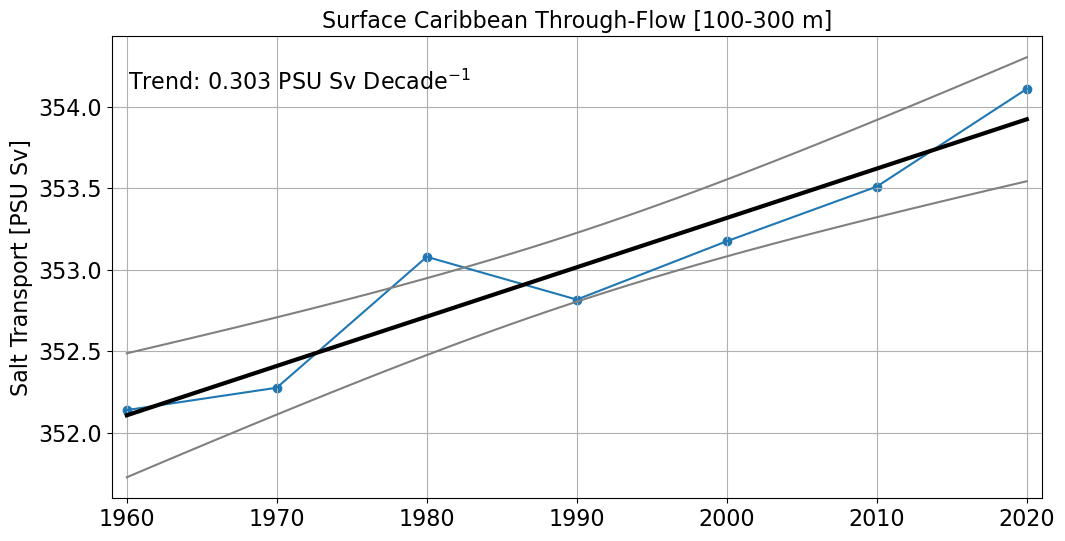

In [280]:
font_size = 16

plt.figure(figsize=(12,6))
plt.plot(salt_transport_ctf.decade.values,surf_salt_transport_ctf.sum(dim='depth')/(10**6))
plt.scatter(salt_transport_ctf.decade.values,surf_salt_transport_ctf.sum(dim='depth')/(10**6))
plt.grid()
plt.ylabel('Salt Transport [PSU Sv]',fontsize=font_size)
#plt.ylim(355,360)
plt.xlim(1959,2021)
plt.title('Surface Caribbean Through-Flow [100-300 m]',fontsize=font_size)

plt.plot(salt_transport_ctf.decade.values,trend_surf_ctf_salt_transport,color='black',linewidth=3)
plt.plot(p_x_surf_salt_transport_ctf, lower_surf_salt_transport_ctf, color='grey')
plt.plot(p_x_surf_salt_transport_ctf, upper_surf_salt_transport_ctf, color='grey')

plt.text(1960.1,354.1,'Trend: '+str(np.round(decadal_slope_surf_ctf_salt_transport*10,3))+' PSU Sv Decade$^{-1}$',size=font_size,color='black')

plt.gca().tick_params(axis='both', which='major', labelsize=font_size)


In [260]:
decadal_p_surf_ctf_salt_transport

0.0009032398079208638

## Now try with absolute salinity

In [261]:
salt_transport_ctf = decadal_mean_ds_ctf.salt*yucatan_transport_per_unit_depth_repeated
salt_transport_atl = decadal_ds_interp.absolute_salinity*atl_transport_per_unit_depth
net_salt_transport = salt_transport_ctf.sum(dim='depth') + salt_transport_atl.sum(dim=['depth','longitude','latitude']).values
net_salt_transport/(10**6)

<xarray.DataArray 'salt' (decade: 7)>
array([52.21204253, 52.75982133, 55.02031849, 51.24331471, 51.59758489,
       53.93825476, 53.96041054])
Coordinates:
  * decade   (decade) int64 1960 1970 1980 1990 2000 2010 2020

In [288]:
net_salt_transport.mean()/(10**6)

<xarray.DataArray 'salt' ()>
array(52.96167818)

In [289]:
(salt_transport_ctf.mean(dim='depth')/(10**6)).mean()

<xarray.DataArray 'salt' ()>
array(1.26873104)

In [264]:
surf_salt_transport_ctf = salt_transport_ctf.where((salt_transport_ctf.depth>=100)&(salt_transport_ctf.depth<=300),drop=True)
surf_salt_transport_atl = salt_transport_atl.where((salt_transport_atl.depth>=100)&(salt_transport_atl.depth<=300),drop=True)

decadal_slope_surf_ctf_salt_transport, decadal_intercept_surf_ctf_salt_transport, decadal_r_surf_ctf_salt_transport, decadal_p_surf_ctf_salt_transport, decadal_e_surf_ctf_salt_transport = linregress(surf_salt_transport_ctf.decade.values, surf_salt_transport_ctf.sum(dim='depth')/(10**6))

trend_surf_ctf_salt_transport = decadal_intercept_surf_ctf_salt_transport + decadal_slope_surf_ctf_salt_transport*surf_salt_transport_ctf.decade.values


# Fit x to y
p_surf_salt_transport_ctf, y_err_surf_salt_transport_ctf = lin_fit(surf_salt_transport_ctf.decade.values, surf_salt_transport_ctf.sum(dim='depth').values/(10**6))
# Calculate confidence intervals
p_x_surf_salt_transport_ctf, confs_surf_salt_transport_ctf = conf_calc(surf_salt_transport_ctf.decade.values, y_err_surf_salt_transport_ctf, 0.975)
# The fit line, and lower and upper confidence bounds
p_y_surf_salt_transport_ctf, lower_surf_salt_transport_ctf, upper_surf_salt_transport_ctf = ylines_calc(p_x_surf_salt_transport_ctf, confs_surf_salt_transport_ctf, p_surf_salt_transport_ctf)

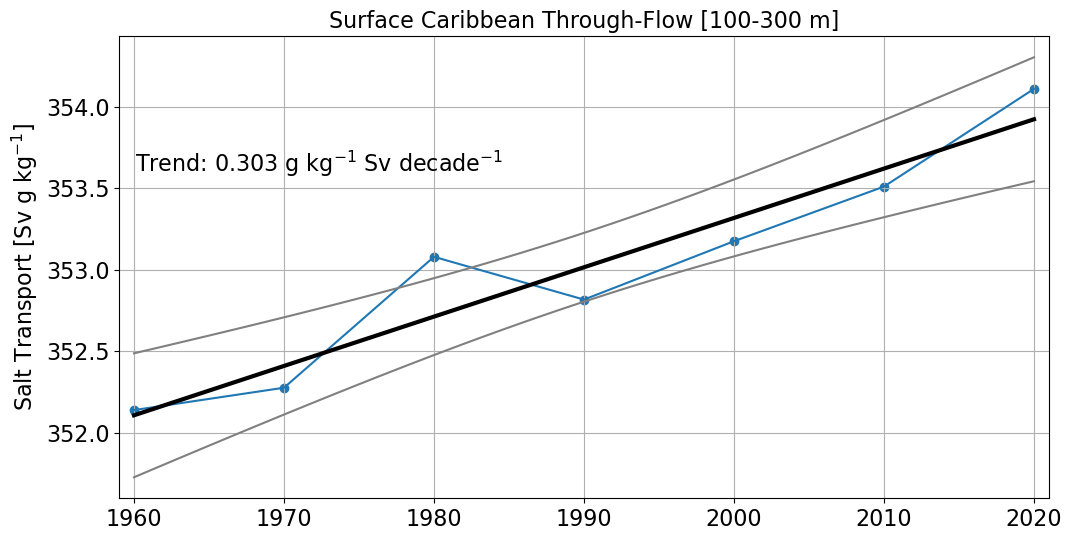

In [278]:
font_size = 16

plt.figure(figsize=(12,6))
plt.plot(salt_transport_ctf.decade.values,surf_salt_transport_ctf.sum(dim='depth')/(10**6))
plt.scatter(salt_transport_ctf.decade.values,surf_salt_transport_ctf.sum(dim='depth')/(10**6))
plt.grid()
plt.ylabel('Salt Transport [Sv g kg$^{-1}$]',fontsize=font_size)
#plt.ylim(357,361)
plt.xlim(1959,2021)
plt.title('Surface Caribbean Through-Flow [100-300 m]',fontsize=font_size)

plt.plot(salt_transport_ctf.decade.values,trend_surf_ctf_salt_transport,color='black',linewidth=3)
plt.plot(p_x_surf_salt_transport_ctf, lower_surf_salt_transport_ctf, color='grey')
plt.plot(p_x_surf_salt_transport_ctf, upper_surf_salt_transport_ctf, color='grey')

plt.text(1960.1,353.6,'Trend: '+str(np.round(decadal_slope_surf_ctf_salt_transport*10,3))+' g kg$^{-1}$ Sv decade$^{-1}$',size=font_size,color='black')

plt.gca().tick_params(axis='both', which='major', labelsize=font_size)


## Finally freshwater flux
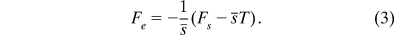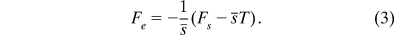

In [303]:
sbar = decadal_ds_interp.isel(latitude=0).practical_salinity.mean().values
sbar

array(35.20510269)

## Greater Atlantic First

In [316]:
atl_freshwater_transport = (-1/sbar)*((decadal_ds_interp.practical_salinity*atl_transport_per_unit_depth)-(atl_transport_per_unit_depth*sbar))
ctf_freshwater_transport = (-1/sbar)*((decadal_mean_ds_ctf.practical_salinity*yucatan_transport_per_unit_depth_repeated)-(yucatan_transport_per_unit_depth_repeated*sbar))
net_freshwater_transport = atl_freshwater_transport.sum(dim=['depth','latitude','longitude']).values+ctf_freshwater_transport.sum(dim='depth').values
net_freshwater_transport.std()/(10**6)

0.03640118876781143

In [320]:
atl_freshwater_transport.sum(dim=['depth','latitude','longitude']).std().values/(10**6)

0.008777757984187801

Text(0.5, 1.0, 'Greater Atlantic: 21.5°N')

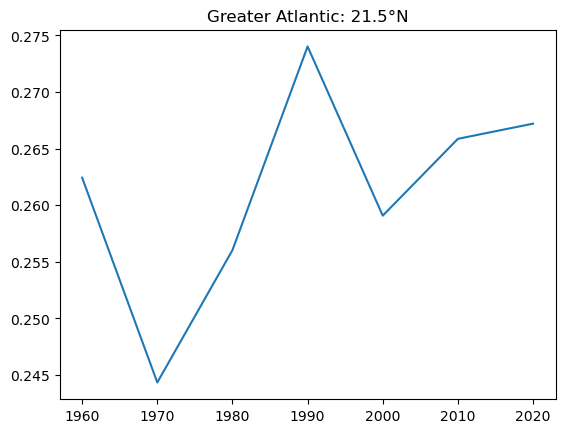

In [305]:
plt.plot(atl_freshwater_transport.time,atl_freshwater_transport.sum(dim=['depth','latitude','longitude'])/(10**6))
plt.title('Greater Atlantic: 21.5°N')

Text(0.5, 1.0, 'Caribbean Through-Flow')

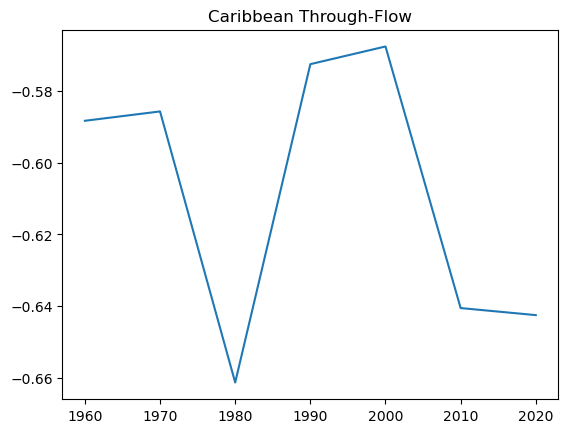

In [306]:
plt.plot(ctf_freshwater_transport.decade,ctf_freshwater_transport.sum(dim='depth')/(10**6))
plt.title('Caribbean Through-Flow')

Text(0.5, 1.0, 'Net Treshwater Transport')

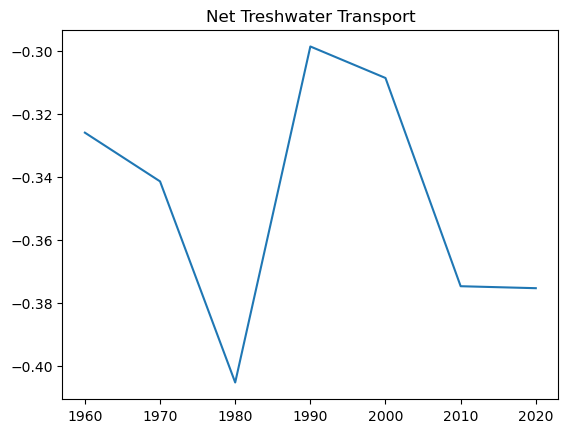

In [307]:
plt.plot(ctf_freshwater_transport.decade,net_freshwater_transport/(10**6))
plt.title('Net Treshwater Transport')

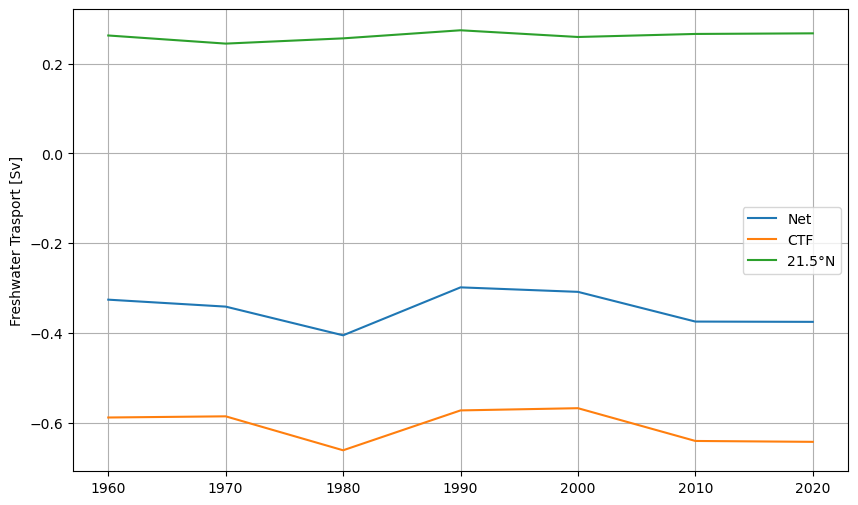

In [308]:
plt.figure(figsize=(10,6))
plt.plot(ctf_freshwater_transport.decade,net_freshwater_transport/(10**6),label='Net')
plt.plot(ctf_freshwater_transport.decade,ctf_freshwater_transport.sum(dim='depth')/(10**6),label='CTF')
plt.plot(atl_freshwater_transport.time,atl_freshwater_transport.sum(dim=['depth','latitude','longitude'])/(10**6),label='21.5°N')
plt.ylabel('Freshwater Trasport [Sv]')
plt.legend()
plt.grid()

In [309]:
linregress(net_heat_transport.decade,net_freshwater_transport)


LinregressResult(slope=-421.9765043439797, intercept=492667.2349071324, rvalue=-0.2318476503806502, pvalue=0.6168959244754774, stderr=791.7767600853459, intercept_stderr=1575715.3261142843)

In [310]:
np.mean(net_freshwater_transport)/(10**6)

-0.3470660087373872

In [323]:
ctf_freshwater_transport.sum(dim='depth').mean().values/(10**6)

-0.6083441168236204

In [312]:
atl_freshwater_transport.sum(dim=['depth','latitude','longitude']).mean().values/(10**6)

0.2612781080862333

In [313]:
slope_net_fw, intercept_net_fw, r_net_fw, p_net_fw, e_net_fw = linregress(ctf_freshwater_transport.decade.values, net_freshwater_transport)
slope_net_fw/(10**5)

-0.004219765043439797

In [314]:
p_net_fw

0.6168959244754774

In [190]:
ctf_fw_trsp_non_smw = (ctf_freshwater_transport.where((ctf_freshwater_transport.depth>=250),drop=True).sum(dim='depth'))+(ctf_freshwater_transport.where((ctf_freshwater_transport.depth<=75),drop=True).sum(dim='depth'))
ctf_fw_trsp_smw = (ctf_freshwater_transport.where((ctf_freshwater_transport.depth>=75)&(ctf_freshwater_transport.depth<=250),drop=True).sum(dim='depth'))
                                                                                                                 

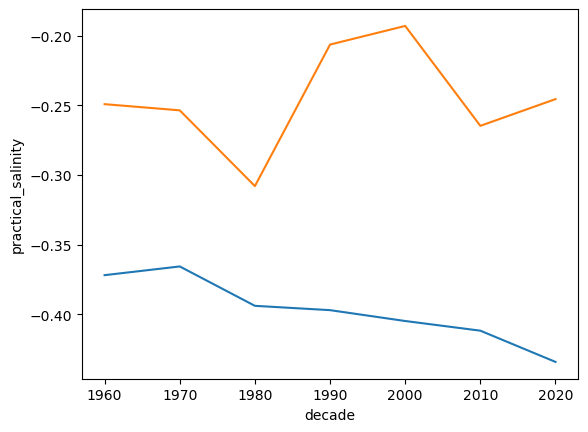

In [191]:
(ctf_fw_trsp_smw/(10**6)).plot()
(ctf_fw_trsp_non_smw/(10**6)).plot()

In [192]:
ctf_fw_trsp_non_smw.values/(10**6)

array([-0.2491242 , -0.25355212, -0.3078988 , -0.20637236, -0.19299621,
       -0.26467068, -0.2455057 ])

In [193]:
slope_ctf_fw_trsp_smw, intercept_ctf_fw_trsp_smw, r_ctf_fw_trsp_smw, p_ctf_fw_trsp_smw, e_ctf_fw_trsp_smw = linregress(ctf_fw_trsp_smw.decade.values, ctf_fw_trsp_smw.values/(10**6))

trend_ctf_fw_trsp_smw = intercept_ctf_fw_trsp_smw + slope_ctf_fw_trsp_smw*ctf_fw_trsp_smw.decade.values

# Fit x to y
p_ctf_fw_trsp_smw, y_err_ctf_fw_trsp_smw = lin_fit(ctf_fw_trsp_smw.decade.values, ctf_fw_trsp_smw.values/(10**6))
# Calculate confidence intervals
p_x_ctf_fw_trsp_smw, confs_ctf_fw_trsp_smw = conf_calc(ctf_fw_trsp_smw.decade.values, y_err_ctf_fw_trsp_smw, 0.975)
# The fit line, and lower and upper confidence bounds
p_y_ctf_fw_trsp_smw, lower_ctf_fw_trsp_smw, upper_ctf_fw_trsp_smw = ylines_calc(p_x_ctf_fw_trsp_smw, confs_ctf_fw_trsp_smw, p_ctf_fw_trsp_smw)

In [194]:
slope_ctf_fw_trsp_smw*10

-0.010348155516859105

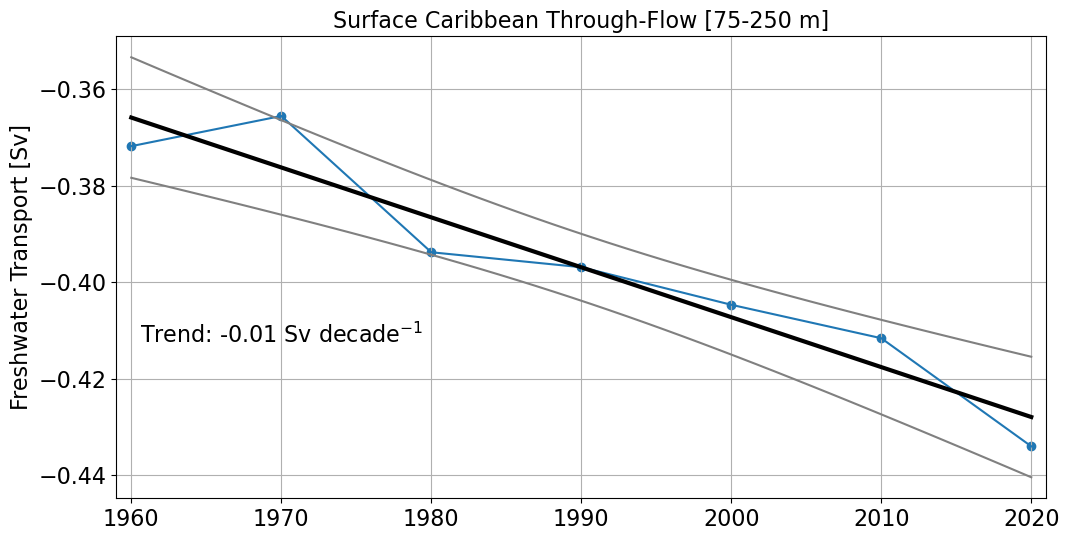

In [195]:
font_size = 16

plt.figure(figsize=(12,6))
plt.plot(ctf_fw_trsp_smw.decade.values,ctf_fw_trsp_smw/(10**6))
plt.scatter(ctf_fw_trsp_smw.decade.values,ctf_fw_trsp_smw/(10**6))
plt.grid()
plt.ylabel('Freshwater Transport [Sv]',fontsize=font_size)
#plt.ylim(357,361)
plt.xlim(1959,2021)
plt.title('Surface Caribbean Through-Flow [75-250 m]',fontsize=font_size)

plt.plot(ctf_fw_trsp_smw.decade.values,trend_ctf_fw_trsp_smw,color='black',linewidth=3)
plt.plot(p_x_ctf_fw_trsp_smw, lower_ctf_fw_trsp_smw, color='grey')
plt.plot(p_x_ctf_fw_trsp_smw, upper_ctf_fw_trsp_smw, color='grey')

plt.text(1960.6,-0.4125,'Trend: '+str(np.round(slope_ctf_fw_trsp_smw*10,3))+' Sv decade$^{-1}$',size=font_size,color='black')

plt.gca().tick_params(axis='both', which='major', labelsize=font_size)
